# Preliminaries
First of all, prerequired modules and packages are imported 
and the default options for plot are set.

## Install

In [ ]:
###!pip install numpy scipy pandas matplotlib scikit-learn tensorflow keras
!pip install qutip
# from __future__ import absolute_import, division, print_function
import qutip as Q

     |████████████████████████████████| 3.5MB 4.7MB/s 
  Created wheel for qutip: filename=qutip-4.5.0-cp36-cp36m-linux_x86_64.whl size=12883506 sha256=b495d39548821720f006f4f6c7890883e9c61b9489df84c17c5bc797b8993cc2
  Stored in directory: /root/.cache/pip/wheels/c9/85/e8/3fbad9a0816141b4c5f1d73d8a880ed91265fea84192cbe37b
Successfully built qutip


## Imports

In [ ]:
%time
import time
##################
import warnings
import pickle
import io, requests, zipfile
import contextlib # redirect_stdout
import sys

#####
import multiprocessing as mp # Pool , cpu_count
import numpy as np
import scipy as sp
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import sklearn as sk #submodules does not import automatically

#from numba import jit, prange
###############################################################
import scipy.optimize # minimize
import scipy.stats # expon
#####
import sklearn.utils 
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
#####
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.decomposition import PCA 
from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap, SpectralEmbedding, TSNE
#####
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
#####
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
#####

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs


## Setting some Options

In [ ]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size

#####
warnings.filterwarnings('always')
#warnings.filterwarnings('ignore')
#####
np.random.seed(7) # fix random seed for reproducibility
#####
org_stdout=sys.stdout

# Functions and Classes
The following user-defined functions and classes are written to make the main code more readable and compact.

## Data Collection / Generation

The method used for data generation is to use qutip module and generate a Random Density Matrice and then Calculate the 
Measurements on the Generated Density Matrice 


by calculating the determinant of the parital transposed density matrix, it can be de decided whether the state is entangled or not.

The matrix of features is in the form:

 $$Features = \begin{bmatrix}
\sigma_x\otimes\sigma_x & \sigma_x\otimes\sigma_y & \sigma_x\otimes\sigma_z & \sigma_x\otimes\ \mathbb{1} 
\\ \sigma_y\otimes\sigma_x & \sigma_y\otimes\sigma_y & \sigma_y\otimes\sigma_z & \sigma_y\otimes\ \mathbb{1}
\\ \sigma_z\otimes\sigma_x & \sigma_z\otimes\sigma_y & \sigma_z\otimes\sigma_z & \sigma_z\otimes\ \mathbb{1}
\\ \mathbb{1}\otimes\sigma_x & \mathbb{1}\otimes\sigma_y & \mathbb{1}\otimes\sigma_z & \mathbb{1}\otimes\ \mathbb{1}
\end{bmatrix}$$

The features are then reformed to (15 , 1) shape where $$ \mathbb{1} \otimes \mathbb{1} $$ feature is ommited since it's always 1.


The following function 'data_gen' recieves 'N' of type int, the number of samples to generate, and 'verbose' of type int, the vorbosity to report during generation.

return type is a DataFrame contains N records of random density matrices and contains following fields:

-15 features for the density matrix

-the PPT criterion, which is the determinant of the partial transpose of the bi-partite system. The PPT criterion says that if this value is negative, then the density matrix is entangled and if positive, then it is seprable

-the binary class of these matrices, where label '1' is for entangled matrices and '0' denotes the class of seprable matrices.


the following functions, "my_data_gen" is used to generate the data and return a pandas dataframe

In [ ]:
def my_gen(N):
  a=time.time()
  seed=int((a*10 - int(a*10))*1_000_000_000)
  np.random.seed(seed)
  ###
  sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
  X = np.empty((N,15))
  y = np.empty(N)
  yc = np.empty(N,dtype=np.int64)

  for k in range(N):
    rho1 = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
    f = [ (rho1* Q.tensor(A,B)).tr().real for A in sigma for B in sigma ]
    del f[-1]
    X[k] = f
    rho2 = Q.partial_transpose(rho1, [0,1] )
    y[k] = np.linalg.det(rho2.full()).real
  yc = pd.DataFrame(y<0,columns=['is_entangled'])
  y=pd.DataFrame(y,columns=['entanglement'])
  sigma = ['sigma_x','sigma_y','sigma_z','I']
  columns = ['{} {}'.format(A,B) for A in sigma for B in sigma]
  del columns[-1]
  X = pd.DataFrame(X,columns=columns)
  return pd.concat([X,y,yc],axis=1)

def my_data_gen(N, n_jobs=-1):
  '''
  N : int : number of samples : O(N)
  n_jobs : int : number of processors for parallel computing, -1  for max possible

  --- return ---
  data : pd.DataFrame : data
  '''

  t=time.time()
  if n_jobs == -1: n_jobs = mp.cpu_count()
  print('running with n_jobs : {}'.format(n_jobs))
  f=n_jobs*100
  N_list = [N//f]*f + [N%f]

  data_list=[]
  with mp.Pool(processes=n_jobs) as pool:
      for i,data in enumerate(pool.imap_unordered(my_gen,N_list) , 1):
          elapsed_time = int(time.time()-t)
          sys.stderr.write('\rdone {:.2%} , time : {} min , {} s , estimated total time : {} min , {} s '.format( i/len(N_list) , elapsed_time//60 , elapsed_time%60 , int(len(N_list)/i * elapsed_time)//60 , int(len(N_list)/i * elapsed_time)%60 ))
          data_list += [data]

  data=pd.concat(data_list)
  return data

In [ ]:
def gen_sep(N):
  sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
  X = np.empty((N,15))
  for k in range(N):
    a=time.time()
    seed=int((a*10 - int(a*10))*1_000_000_000)
    np.random.seed(seed)
    rho1 = Q.tensor(Q.rand_dm(2) , Q.rand_dm(2))
    f = [ (rho1* Q.tensor(A,B)).tr().real for A in sigma for B in sigma ]
    del f[-1]
    X[k] = f
    sigma = ['sigma_x','sigma_y','sigma_z','I']
    columns = ['{} {}'.format(A,B) for A in sigma for B in sigma]
    del columns[-1]
    X = pd.DataFrame(X,columns=columns)
    return X

In [ ]:
def my_gen_3(N):
  a=time.time()
  seed=int((a*10 - int(a*10))*1_000_000_000)
  np.random.seed(seed)
  ###
  sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
  X = np.empty((N,15))
  y = np.empty(N)
  yc = np.empty(N,dtype=np.int64)

  for k in range(N):
    rho1 = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
    f = [ (rho1* Q.tensor(A,B)).tr().real for A in sigma for B in sigma ]
    del f[-1]
    X[k] = f
    rho2 = Q.partial_transpose(rho1, [0,1] )
    y[k] = np.linalg.det(rho2.full()).real
  yc = pd.DataFrame(y<0,columns=['is_entangled'])
  y=pd.DataFrame(y,columns=['entanglement'])
  sigma = ['sigma_x','sigma_y','sigma_z','I']
  columns = ['{} {}'.format(A,B) for A in sigma for B in sigma]
  del columns[-1]
  X = pd.DataFrame(X,columns=columns)
  return pd.concat([X,y,yc],axis=1)

def my_data_gen(N, n_jobs=-1):
  '''
  N : int : number of samples : O(N)
  n_jobs : int : number of processors for parallel computing, -1  for max possible

  --- return ---
  data : pd.DataFrame : data
  '''

  t=time.time()
  if n_jobs == -1: n_jobs = mp.cpu_count()
  print('running with n_jobs : {}'.format(n_jobs))
  f=n_jobs*100
  N_list = [N//f]*f + [N%f]

  data_list=[]
  with mp.Pool(processes=n_jobs) as pool:
      for i,data in enumerate(pool.imap_unordered(my_gen,N_list) , 1):
          elapsed_time = int(time.time()-t)
          sys.stderr.write('\rdone {:.2%} , time : {} min , {} s , estimated total time : {} min , {} s '.format( i/len(N_list) , elapsed_time//60 , elapsed_time%60 , int(len(N_list)/i * elapsed_time)//60 , int(len(N_list)/i * elapsed_time)%60 ))
          data_list += [data]

  data=pd.concat(data_list)
  return data

In [ ]:
x=gen_sep(100)
x.duplicated().sum()

0

## data gen with symmetry

In [ ]:
def symm(f,symmet='x'):
  '''
  x symmetry
  '''
  f=np.array(f).reshape(4,4)
  if symmet=='x':
    f[0][1]= 0
    f[0][2]= 0
    f[0][3]= 0
    f[1][0]= 0
    f[2][0]= 0
    f[3][0] = 0
  #####
  if symmet=='Rz':
    #f[3][3]
    f[3][0]= 0
    f[3][1]= 0
    #f[3][2]
    f[0][3]=0
    f[0][0]= 1/2*(f[1][1]+f[2][2]) #
    f[0][1]= 1/2*(f[1][2]-f[2][1])
    f[0][2]= 0
    f[1][3]=0
    f[1][0]= 1/2*(f[2][1]-f[1][2])
    f[1][1]= 1/2*(f[1][1]+f[2][2])
    f[1][2]=0
    #f[2][3]
    f[2][0]=0
    f[2][1]=0
    #f[2][2]    
  #####
  sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
  rho = 1/4*sum([ (f[i,j]* Q.tensor(sigma[i],sigma[j])) for i in range(4) for j in range(4) ])
  f = np.delete(f.reshape(-1),-1)
  return f , rho

In [ ]:
def my_gen(N):
  symmet='Rz'
  a=time.time()
  seed=int((a*10 - int(a*10))*1_000_000_000)
  np.random.seed(seed)
  sigma=[ Q.sigmax(), Q.sigmay(), Q.sigmaz(), Q.identity(2)]
  X = np.empty((N,15))
  y = np.empty(N)
  yc = np.empty(N,dtype=np.int64)

  for k in range(N):
    rho1 = Q.rand_dm(4,dims=[ [2,2] , [2,2] ] )
    f = [ (rho1* Q.tensor(A,B)).tr().real for A in sigma for B in sigma ]
    X[k] , rho1 = symm(f,symmet=symmet)
    rho2 = Q.partial_transpose(rho1, [0,1] )
    y[k] = np.linalg.det(rho2.full()).real
  yc = pd.DataFrame(y<0,columns=['is_entangled'])
  y=pd.DataFrame(y,columns=['entanglement'])
  sigma = ['sigma_x','sigma_y','sigma_z','I']
  columns = ['{} {}'.format(A,B) for A in sigma for B in sigma]
  del columns[-1]
  X = pd.DataFrame(X,columns=columns)
  return pd.concat([X,y,yc],axis=1)

def my_data_gen(N, n_jobs=-1):
  '''
  N : int : number of samples : O(N)
  n_jobs : int : number of processors for parallel computing, -1  for max possible

  --- return ---
  data : pd.DataFrame : data
  '''

  t=time.time()
  if n_jobs == -1: n_jobs = mp.cpu_count()
  print('running with n_jobs : {}'.format(n_jobs))
  f=n_jobs*100
  N_list = [N//f]*f + [N%f]

  data_list=[]
  with mp.Pool(processes=n_jobs) as pool:
      for i,data in enumerate(pool.imap_unordered(my_gen,N_list) , 1):
          elapsed_time = int(time.time()-t)
          sys.stderr.write('\rdone {:.2%} , time : {} min , {} s , estimated total time : {} min , {} s '.format( i/len(N_list) , elapsed_time//60 , elapsed_time%60 , int(len(N_list)/i * elapsed_time)//60 , int(len(N_list)/i * elapsed_time)%60 ))
          data_list += [data]

  data=pd.concat(data_list)
  return data

## Learning

In [ ]:
def my_GridSearchCV(estimator,x_train,y_train,cv=5,refit='accuracy',pos_label=0):
  if is_clf(estim) :
    scoring = {'AUC': 'roc_auc', 'accuracy': make_scorer(accuracy_score), 'precision':make_scorer(precision_score, pos_label=pos_label)
           , 'recall':make_scorer(recall_score, pos_label=pos_label), 'f1':make_scorer(f1_score, pos_label=pos_label)}
  else :
    scoring = None
    refit = True

  opt_estimator = RandomizedSearchCV(estimator, param_distributions=params_dist[estim], cv=cv, n_jobs=-1,
                                     refit=refit, scoring= scoring,verbose=10)
  #opt_estimator =GridSearchCV(estimator, param_grid=params_dist[estim], cv=cv, n_jobs=-1,
  #                            refit=refit, scoring= scoring, verbose=10)
  opt_estimator.fit( x_train, y_train )

  print("#######################")
  print("Best Score : {} ".format(opt_estimator.best_score_))
  print("Best params : \n  {}".format(opt_estimator.best_params_))
  print("#######################")
  return opt_estimator.best_params_ , opt_estimator.best_estimator_

## Model Analyzing

### Score Analyzing

In [ ]:
def my_clf_score_analyze(clf,X_test,y_test):
  print('##################################################################')
  print('Test Score on test set : {}'.format(clf.score(X_test,y_test)))
  print('----------------------------')
  y_predicted = clf.predict(X_test)
  print('Confusion Matirix : \n')
  print(confusion_matrix(y_test,y_predicted))
  print('----------------------------')
  print(classification_report(y_test,y_predicted))
  print('----------------------------')
  print('AUC : {}'.format(roc_auc_score(y_test,y_predicted)))
  print('----------------------------')
  return

In [ ]:
def my_precision_recall_curve(estimator,X_test,y_test):
  try:
    decision_values = estimator.predict_proba(X_test)
  except:
    decision_values = estimator.decision_function(X_test)
    decision_values = np.concatenate( ((1-decision_values).reshape(-1,1) ,decision_values.reshape(-1,1) ) , axis=1)

  fig, ax = plt.subplots(1, 2, constrained_layout=True,figsize=(12,8))
  fig.suptitle('Precision-Recall Curve for {}'.format(str(estimator)))

  for pos_label in (0,1):
    precision, recall, thresholds = sk.metrics.precision_recall_curve(y_test, decision_values[:,pos_label] ,pos_label=pos_label)
    ax[pos_label].plot(recall, precision)
    ax[pos_label].set_title('for class : {}'.format(pos_label))
    ax[pos_label].set_xlabel('Recall')
    ax[pos_label].set_ylabel('Precision')

  plt.show()
  return precision, recall, thresholds

In [ ]:
'''
def my_roc_curve(estimator,X_test,y_test) ##or mix with above , cuz it's also optimal
  ### roc curve


  fpr, tpr, thrsld_list = roc_curve(y_test, decision_values[:,0])

  plt_title = 'ROC Curve {}'.format(str(estimator))
  x_label = 'False Positive Rate'
  y_label = 'True Positive Rate'

  fig = plt.figure()
  ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
  plt.plot(fpr, tpr)
  plt.show()
'''

### Validation Curve

In [ ]:
def my_validation_curve(estimator,param_name,param_range,X_train,y_train,cv=5):
  train_scores, valid_scores = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range , cv=cv,
                                                verbose=10, n_jobs=-1
                                               )

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  valid_scores_mean = np.mean(valid_scores, axis=1)
  valid_scores_std = np.std(valid_scores, axis=1)

  xlabel = param_name
  ylabel = 'Score'

  plt_title = 'Validation curve for {}'.format(str(estimator))

  fig = plt.figure()
  ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
  plt.semilogx(param_range, train_scores_mean, label="Training score",
               color="darkorange", lw=2)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.2,
                   color="darkorange", lw=2)
  plt.semilogx(param_range, valid_scores_mean, label="Validation score",
               color="navy", lw=2)
  plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                   valid_scores_mean + valid_scores_std, alpha=0.2,
                   color="navy", lw=2)
  plt.legend(loc="best")
  plt.show()
  
  return train_scores, valid_scores

### Learning Curve

In [ ]:
def my_learning_curve(estimator,X,y,train_sizes,cv,n_jobs=-1,verbose=10):
  train_size, train_scores, validation_scores = learning_curve( estimator = estimator , X = X,
                                                     y = y, train_sizes = train_sizes, cv = 5,
                                                     n_jobs=n_jobs,verbose=verbose)#scoring = 'neg_mean_squared_error'

  train_scores_mean = train_scores.mean(axis = 1) # *-1 if neg_mean_squared_error
  train_scores_std = np.std(train_scores, axis=1)
  validation_scores_mean = validation_scores.mean(axis = 1)
  validation_scores_std  = validation_scores.std(axis = 1)

  xlabel = 'Sample Size'
  ylabel = 'Score' #'L2-loss'
  plt_title = 'Learning curve for {}'.format(str(estimator))

  fig = plt.figure()
  ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
  ax.plot(train_size, train_scores_mean, label = 'Training Score')
  ax.plot(train_size, validation_scores_mean, label = 'Validation Score')

  plt.fill_between(train_size, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.2,
                   color="darkblue", lw=2)
  plt.fill_between(train_size, validation_scores_mean - validation_scores_std,
                   validation_scores_mean + validation_scores_std, alpha=0.2,
                   color="darkgreen", lw=2)

  ax.legend(loc=0)

  print('######################')
  print('Last Training Score : {}'.format(train_scores_mean[-1]))
  print('Last Validation score : {}'.format(validation_scores_mean[-1]))
  print('######################')
  plt.show()
  return train_size, train_scores, validation_scores

## Classifier from Regressor
This class recieves a regressor, and make a classifier from that.

In [ ]:
class my_clf_from_reg(sk.base.BaseEstimator):
  
  #coef_ = lin_reg.coef_
  def __init__(self,reg):
    self.reg = reg
  
  def __str__(self):
    return str(self.reg)
  
  def predict(self,X_test):
    Nt = X_test.shape[0]
    pre_y = self.reg.predict(X_test)
    pre_yc = pre_y < 0
    return pre_yc
  
  def score(self,X_test,yc_test):
    Nt = X_test.shape[0]
    pre_yc=self.predict(X_test)
    err = (yc_test^pre_yc)
    return (Nt-err.sum()) /float(Nt)
  
  def fit(self,X_train,y_train):
    self.reg.fit(X_train,y_train)
    print('reg train score : ', str(self.reg.score(X_train,y_train)))
    return self.reg
  
  def decision_function(self,X):
    return -1*self.reg.predict(X)
  
  def wrong_indices(self,xtest,ytest):
    inds =[]
    Nt = xtest.shape[0]
    pre_yc=self.predict(xtest)
    for i in range(Nt):
      if yctest[i] != pre_yc[i]:
        inds.append(i) 
    return inds

# Main

## Data Collection / Generation
we can generate and save the data in the following code:

In [ ]:
#data = my_data_gen(N=100_000,n_jobs=-1)
#data.to_csv('data.zip', index = False)

or we can load the data from cloud or storage

In [ ]:
url = 'https://www.dropbox.com/s/a7ekqtv84dhb5d6/data_20.zip?dl=1' ###????????????
data = pd.read_csv(url,compression='zip')

In [ ]:
### ctrl + m . #ctrl + F8

## Data Analysis

In [ ]:
print(data.info())
print('number of duplicated data : ',data.duplicated().sum())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 17 columns):
sigma_x sigma_x    float64
sigma_x sigma_y    float64
sigma_x sigma_z    float64
sigma_x I          float64
sigma_y sigma_x    float64
sigma_y sigma_y    float64
sigma_y sigma_z    float64
sigma_y I          float64
sigma_z sigma_x    float64
sigma_z sigma_y    float64
sigma_z sigma_z    float64
sigma_z I          float64
I sigma_x          float64
I sigma_y          float64
I sigma_z          float64
entanglement       float64
is_entangled       bool
dtypes: bool(1), float64(16)
memory usage: 615.1 MB
None


KeyboardInterrupt: ignored

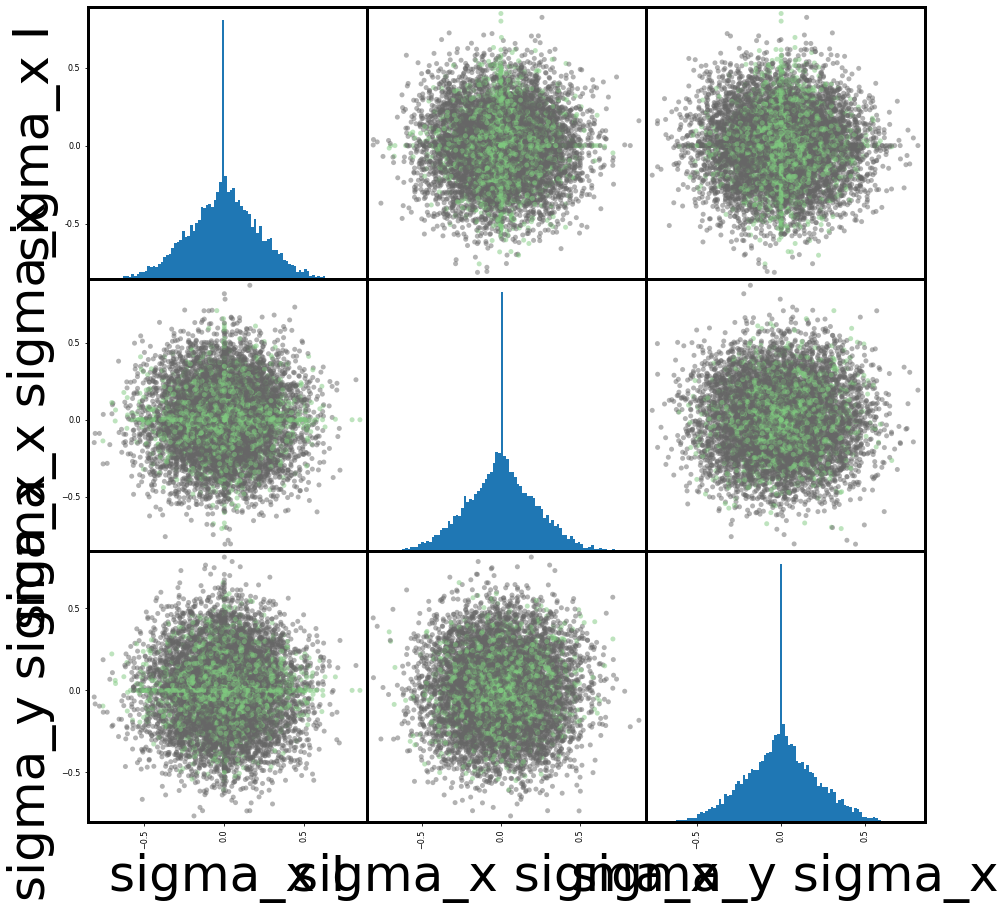

In [ ]:
### Full scatter matrix plot
#data_mini.hist(figsize=(24,14),bins=100)
N_sample=10_000
data_mini = data.sample(N_sample , random_state=0)
target = 'is_entangled'
features=['sigma_x I','sigma_x sigma_x', 'sigma_y sigma_x']
###############3
data_mini[target]=data_mini[target]*1 ### do sth for bool binary

_=pd.plotting.scatter_matrix(data_mini[features], c=data_mini[target] , cmap = plt.cm.Accent,
                            figsize=(len(data_mini[features].columns)*5,len(data_mini[features].columns)*5), marker='o', s=25, 
                            hist_kwds={'bins':100})

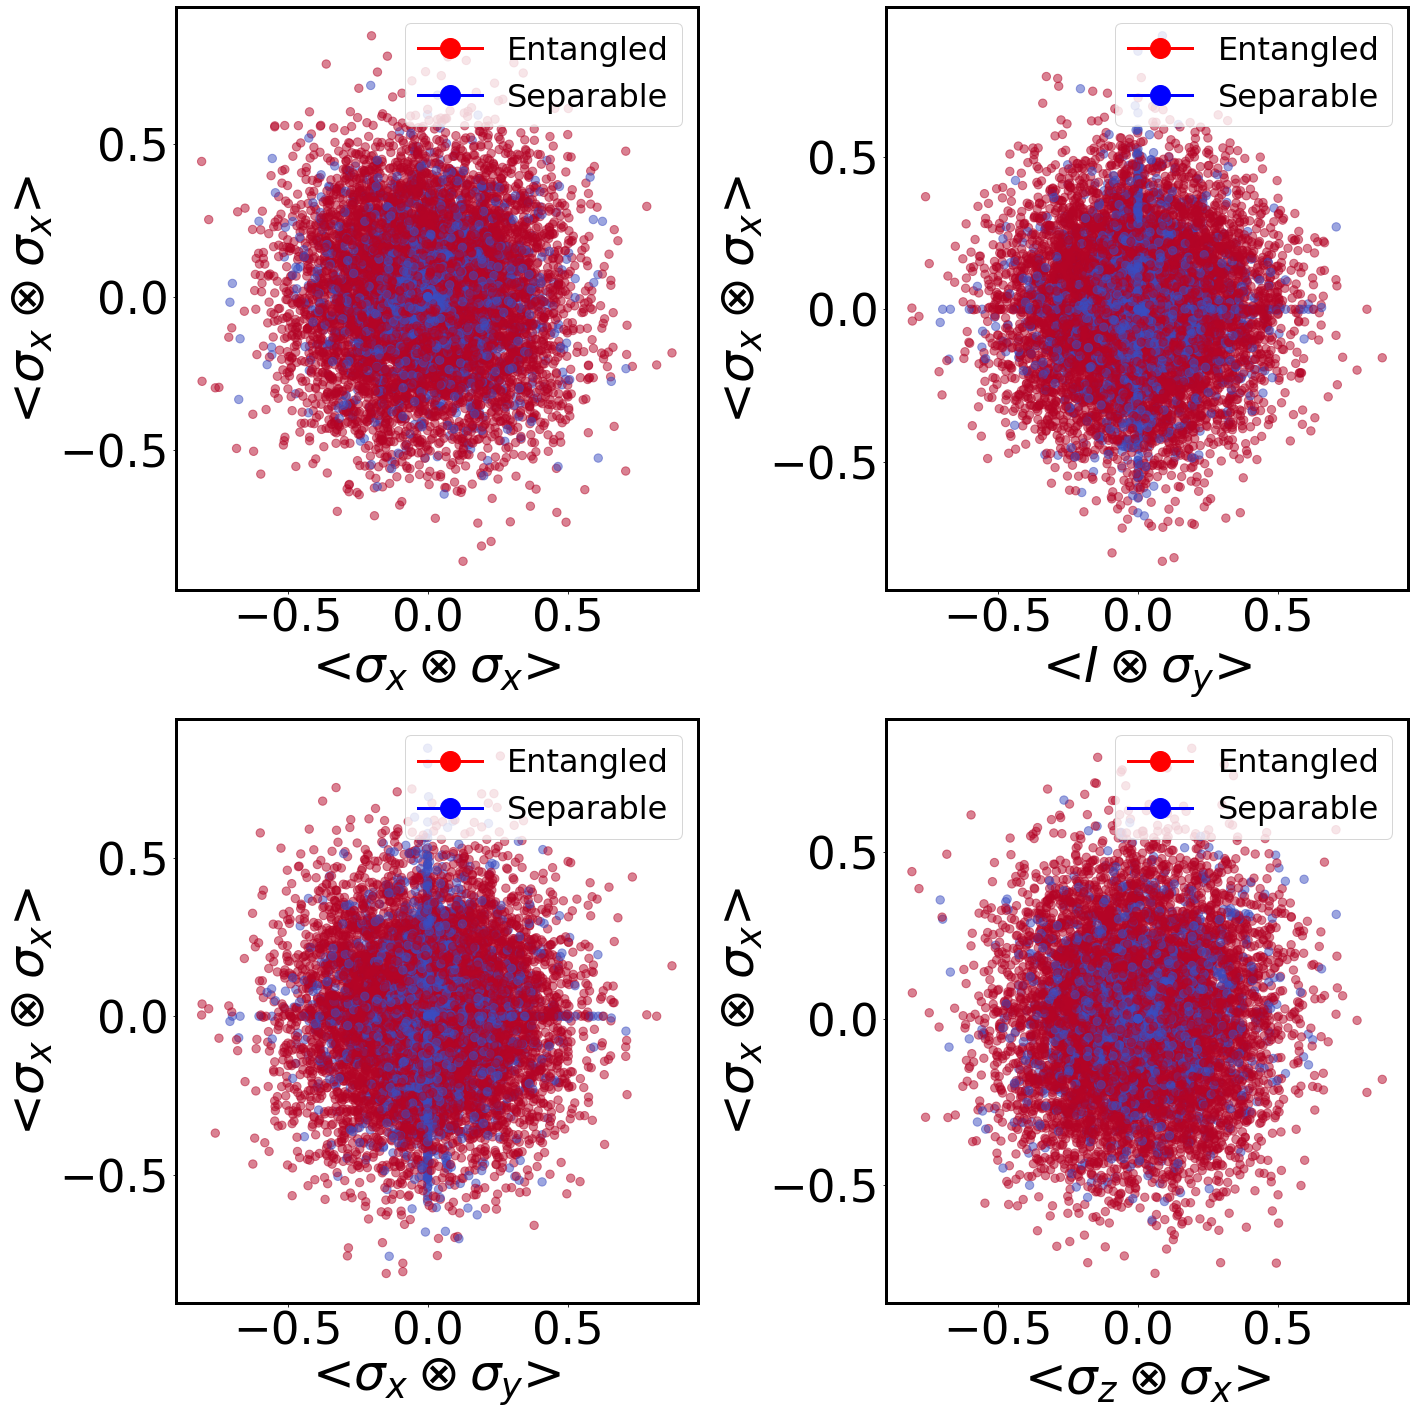

In [ ]:
#@title Scatter Plot

N_sample=10_000
data_mini = data.sample(N_sample , random_state=0)


'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=50)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=45)    # fontsize of the tick labels
plt.rc('ytick', labelsize=45)    # fontsize of the tick labels
plt.rc('legend', fontsize=32)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size



from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker = 'o' , color='r' , markerfacecolor='r', markersize=20),
                Line2D([0], [0], marker = 'o' , color='b' , markerfacecolor='b', markersize=20)]

f = plt.figure(figsize=(20,20))

aa=[r'<$\sigma_x \otimes \sigma_x$>',
r'<$I \otimes \sigma_y$>',
r'<$\sigma_x \otimes \sigma_y$>',
r'<$\sigma_z \otimes \sigma_x$>']


for i in range(1,5):
    ax = f.add_subplot(2, 2, i , xlabel=aa[i-1], ylabel=aa[0],  ) #title=aa[0]+"vs."+aa[i+1]
    ax.scatter(data_mini.values[:,0],data_mini.values[:,i], alpha=0.5, c= data_mini[target] ,s=70, marker = 'o', cmap=plt.cm.coolwarm , edgecolors = 'face' )
    #ax.scatter( sep_xsams[:,0],sep_xsams[:,i], alpha=0.3, c= 'b', s=100 ,marker = '*', cmap=plt.cm.coolwarm , edgecolors = 'face' )
    ax.legend( custom_lines, ['Entangled', 'Separable'], loc=1)    

plt.tight_layout()
plt.show()

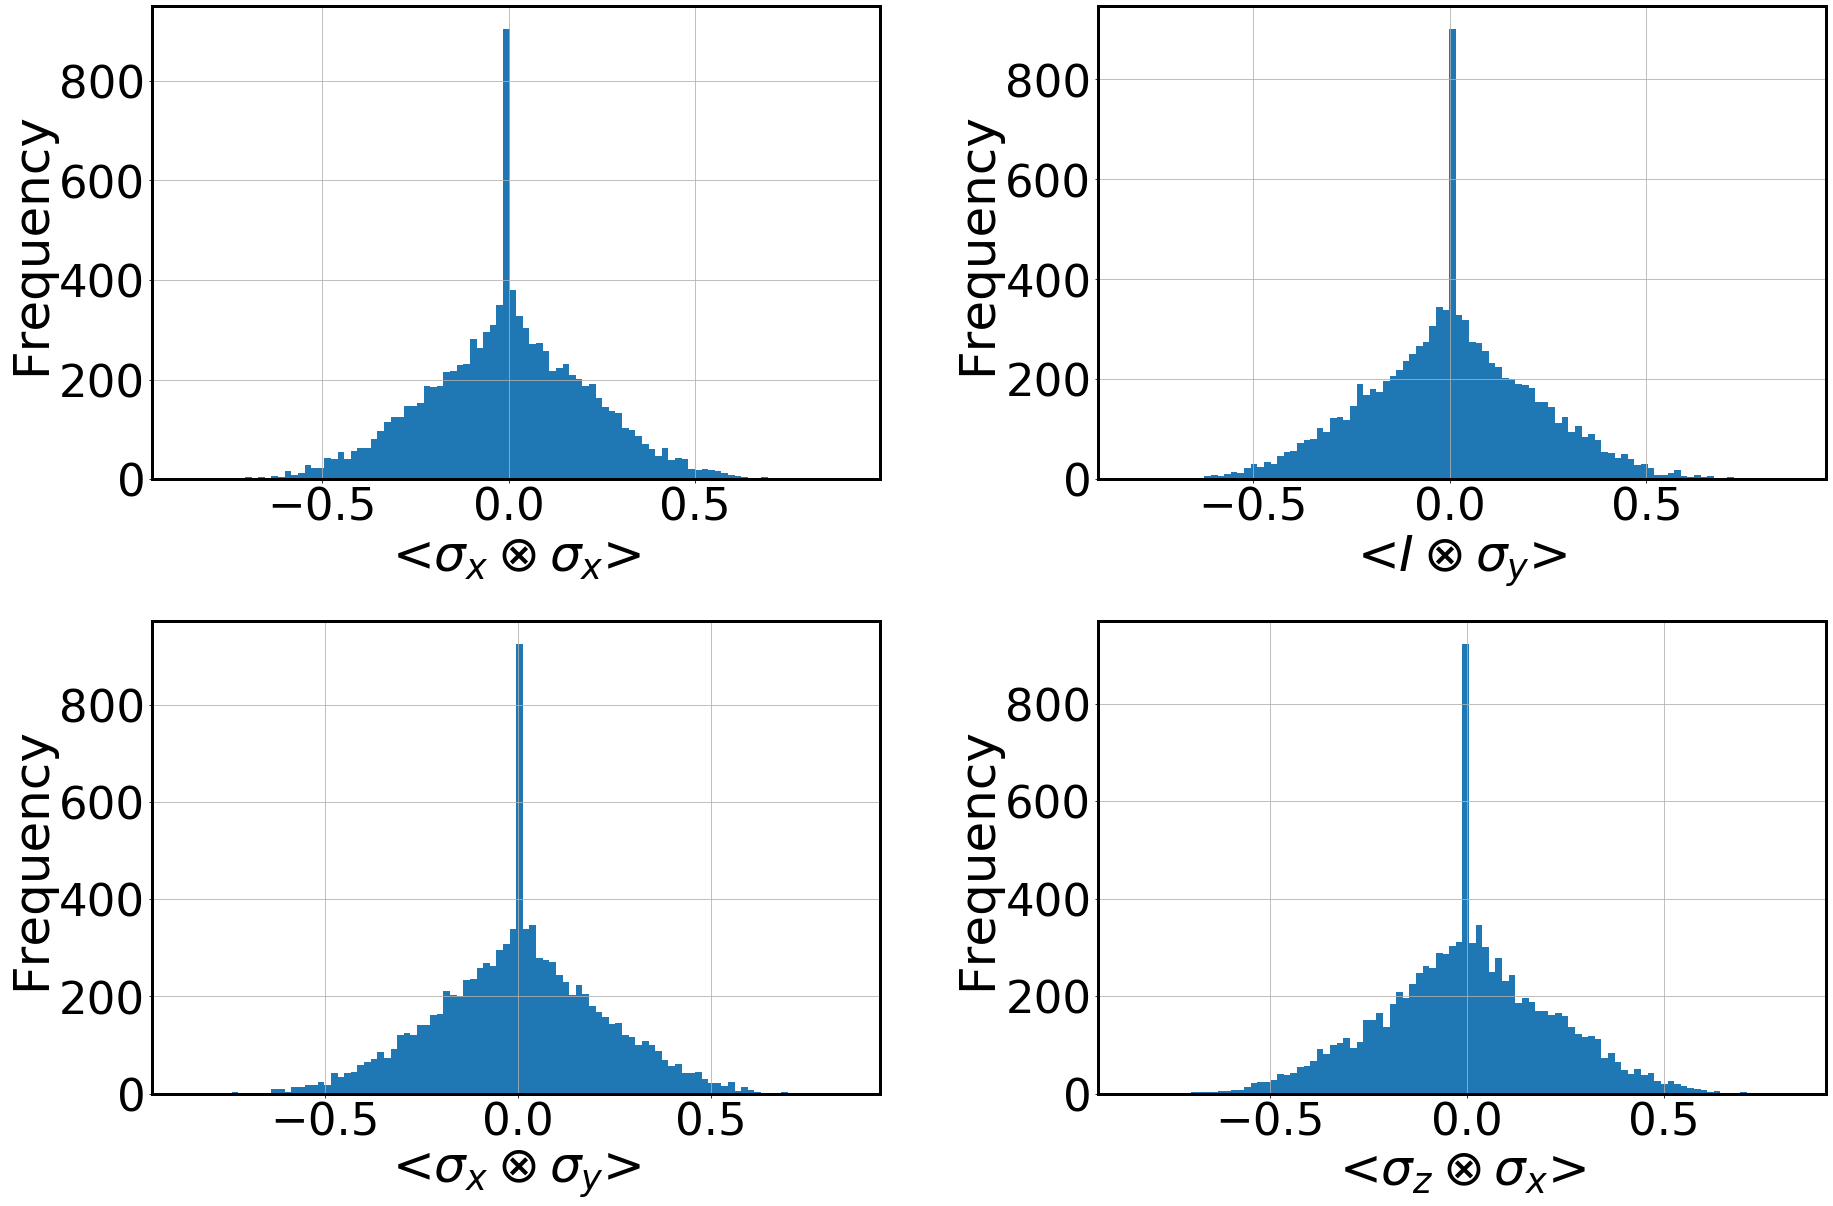

In [ ]:
#@title Histogram
## Histogram Plot
N_sample=10_000
plt.rc('figure', figsize=(30,12) )         # Image size
data_mini = data.sample(N_sample , random_state=0)
data_mini = data_mini.drop(['is_entangled', 'entanglement', 'sigma_y sigma_y','sigma_z sigma_z','sigma_y sigma_x','sigma_x sigma_z','sigma_z sigma_y','sigma_y sigma_z','I sigma_x','sigma_y I','sigma_x I','sigma_z I','I sigma_z'],axis=1)
data_mini[r'<$\sigma_x \otimes \sigma_x$>']=data_mini['sigma_x sigma_x']
data_mini[r'<$I \otimes \sigma_y$>']=data_mini['I sigma_y']
data_mini[r'<$\sigma_x \otimes \sigma_y$>']=data_mini['sigma_x sigma_y']
data_mini[r'<$\sigma_z \otimes \sigma_x$>']=data_mini['sigma_z sigma_x']
data_mini = data_mini.drop(['sigma_x sigma_x','sigma_x sigma_y','sigma_z sigma_x','I sigma_y'],axis=1)


'''Set the defaults for your plots.'''
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=50)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=45)    # fontsize of the tick labels
plt.rc('ytick', labelsize=45)    # fontsize of the tick labels
plt.rc('legend', fontsize=32)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size



fig=data_mini.hist(bins=100 ,figsize=(30,20))

for i,x in enumerate(fig.ravel()):
  x.title.set_size(32)
  x.set_title('')
  x.set_xlabel(data_mini.columns[i])
  x.set_ylabel('Frequency')

As it is seen in the feagure, there is not any obvious corrolations between featrues and entaglement.
Moreover, the histograms are almost gaussian shaped and all the features have ALMOST same histogram. However, there is an issue about the rand_dm method in qutip module, which it doesn't generate symmetric random matrices in each x,y and z direction. It could be easily found from the histogram of these 15 features, where distributions in correspondance to z axis are slightly different from ones to x and y axes.

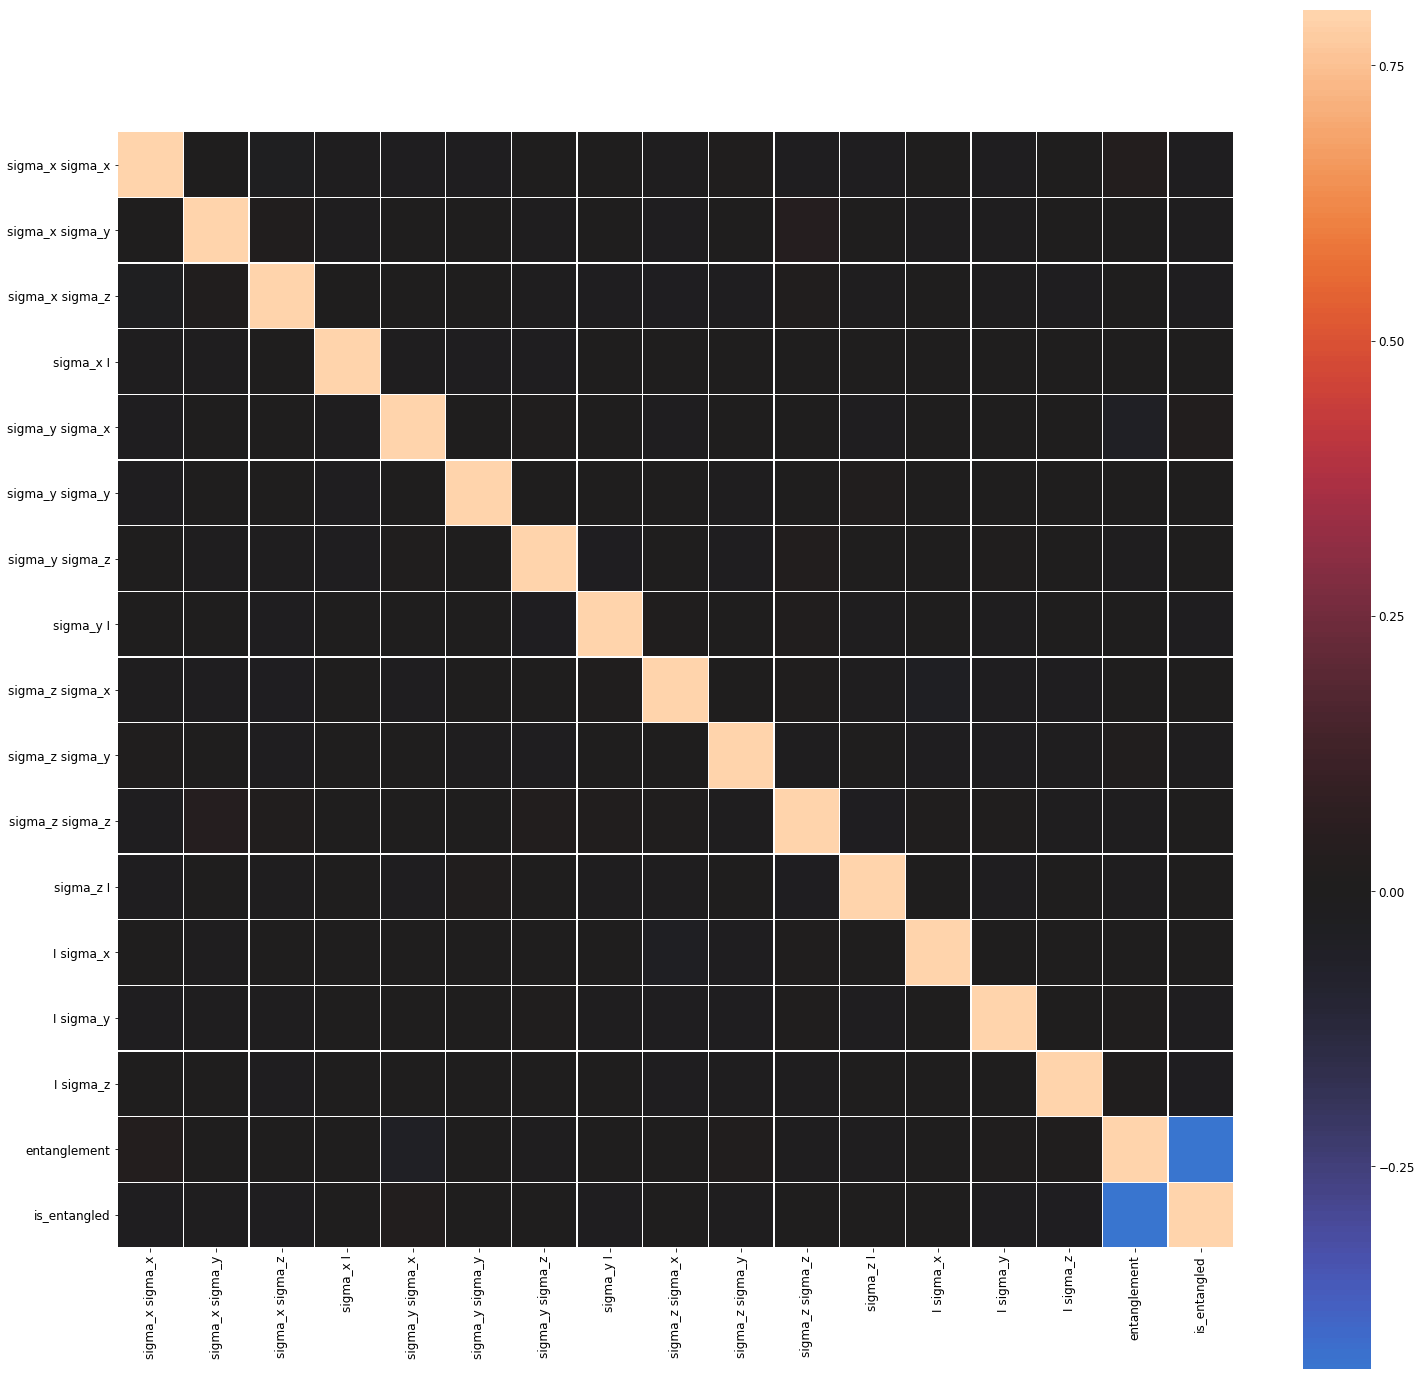

In [ ]:
#@title Correlation
fig = plt.figure(figsize = (25,25))

seaborn.heatmap(data_mini.corr(), vmax = .8, square = True, linewidth=0.3, center=0)
plt.show()

As it is seen in the figure, there is not any linear correlation between features themselves, nor there is any between features and entanglement.

In [ ]:
## Frequency of entangled states
print("{} % of the stored data is entangled ".format(100*(data['is_entangled'].sum())/len(data['is_entangled'])))

68.3852 % of the stored data is entangled 


## Preprocessing / Data Preperation

In [ ]:
%%time
is_clf = True
# is_clf = False
N_sample = 5000_000
test_size=0.05
poly_feature = 0 # 0 or int for degree
scaler = 'StandardScaler' # 'None', 'StandardScaler' , 'RobustScaler' , 'MinMaxScaler'
target_scale = 1

# feature_noise = 0.01*np.random.rand()
feature_noise = 0
omitfeatures = []#['sigma_x sigma_y','sigma_x sigma_z','sigma_x I','sigma_y sigma_x','I sigma_x']
##################################################################################
features=data.columns.drop(['entanglement','is_entangled']+omitfeatures)
if is_clf:
  target='is_entangled'
else:
  target='entanglement'
### missing data
#pd.isna() np.NaN == np.NaN : False
#data_mod = data_mod.dropna()
#df1.fillna() #for id : df1.fillna( df1.mean()['A':'B'] ) columns mean
#df1.fillna(method='pad') # 'backfill'
#df1.interpolate() ##lots of method=''
#df1.replace({0: 10, 1: 100}) #if forexample the misings are not Nan but 0 and 1 


###### augmentation ####
#sample increasing
### DO it ONLY for X_train,y_train ...since we might see a mirrored picture of a test cas .. although literally NO data should be seen from test .. validation data also have the same properties
#test data is like a competition when want to find how well we have done in fanal submit
#different angle rotations
#different mirroring : x , z , mabda
#shifts


###shuffle
data_mod = sk.utils.shuffle(data,random_state=0)
 
### data sampling
data_mini = data_mod.sample(N_sample , random_state=0)

### X , y
X = data_mini[features] + feature_noise
y = data_mini[target]

### cleanup (numeric labels)
if is_clf:
  label_encoder = sk.preprocessing.LabelEncoder()
  y = label_encoder.fit_transform(y)
  #y = label_binarize(y, classes=[0, 1]) #one vs other?
else:
  y = target_scale*y
  
### polynomial feature
if poly_feature != 0:
  polynomial_features = sk.preprocessing.PolynomialFeatures(degree=poly_feature)
  X = polynomial_features.fit_transform(X)

### Scaling
if scaler != 'None':
  scale = eval('sk.preprocessing.'+scaler+'()')
  X = scale.fit_transform(X)

### train_test_split
X_train, X_test , y_train, y_test = sk.model_selection.train_test_split(X, y , random_state=0,test_size=test_size)

CPU times: user 5.61 s, sys: 349 ms, total: 5.96 s
Wall time: 5.77 s


## Classical Methods

In [ ]:
clf_list = [
#   DummyClassifier(strategy='most_frequent'),
#   RidgeClassifier(),
#   SGDClassifier(),
#   GaussianNB(),
#   DecisionTreeClassifier(max_depth=10),
  RandomForestClassifier(n_estimators=100,n_jobs=-1),
#   ExtraTreesClassifier(n_jobs=-1),
#   SVC(), #O(N^2)
#   KNeighborsClassifier(), #O(N^2)
#   BaggingClassifier(),
#   GradientBoostingClassifier(),
#   AdaBoostClassifier()
]

reg_list=[
#     LinearRegression(),
#     Ridge(),
#     Lasso(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(n_estimators=100),
#     SVR(),
#     SVR(kernel='poly',degree=4),
#     KNeighborsRegressor()
]
##################################################################################

clf_reg_list = [my_clf_from_reg(regs) for regs in reg_list ]
table_clf=pd.DataFrame()

def reg_scoring(estimator,X,y): #for reg to clf
      return estimator.score(X,y<0)

if is_clf :
  scoring=None
else:
  scoring=reg_scoring
  


#with open('clf_analysis.txt', 'w') as f:
#    with redirect_stdout(f):
#        print('hi')

# for clf in clf_reg_list:

if not is_clf: clf_list = clf_reg_list

for clf in clf_list:
  
  info = pd.DataFrame()
  info['estimator'] =[str(clf).split('(')[0]]
  info['N_sample']= N_sample
  info['poly_feature']=poly_feature
  info['scaler']= scaler
  
  info_dict = sk.model_selection.cross_validate(clf,X_train,y_train,scoring=scoring,cv=5,n_jobs=-1,verbose=0,return_train_score=True)
  info_mean = pd.DataFrame({key:[info_dict[key].mean()] for key in info_dict.keys()})
  
  info=pd.concat([info,info_mean],axis=1)
  
  print(info)
  table_clf=table_clf.append(info,ignore_index=True)
  
  clf.fit(X_train,y_train)
  print('----------------------------')
  if not is_clf:
    y_testt = y_test<0
  else:
    y_testt = y_test
  my_clf_score_analyze(clf,X_test,y_testt)
  precision, recall, thresholds = my_precision_recall_curve(clf,X_test,y_testt)

                estimator  N_sample  ...  test_score train_score
0  RandomForestClassifier     50000  ...    0.848948         1.0

[1 rows x 8 columns]
----------------------------
##################################################################
Test Score on test set : 0.8512
----------------------------
Confusion Matirix : 



NameError: ignored

In [ ]:
table_clf.to_csv('table_clf.csv',index=False)
table_clf

,estimator,N_sample,poly_feature,scaler,fit_time,score_time,test_score,train_score
0,RandomForestClassifier,1000000,0,StandardScaler,489.277723,7.171384,0.882805,1.0


In [ ]:
tb=pd.read_csv('https://www.dropbox.com/s/utzzsf2vnph4vzi/final_table_clf.csv?dl=1')
ttb=tb.drop(['N_sample','poly_feature','scaler','train_score'],axis=1)


In [ ]:
ttb

,estimator,fit_time,score_time,test_score
0,LinearRegression,85.136894,0.063321,0.996933
1,Ridge,11.969841,0.046773,0.991000
2,RandomForestClassifier,489.277723,7.171384,0.882805
3,SVC,31.243196,4.636604,0.879600
4,SVR,5.256612,0.432860,0.876267
5,RandomForestClassifier,11.762246,0.226973,0.847440
6,RandomForestRegressor,72.659766,0.351008,0.847067
7,SGDClassifier,1.462001,0.032926,0.846801
8,SVR_poly_degree_4,7.652852,0.206586,0.832533
9,BaggingClassifier,5.181504,0.024030,0.831920


In [ ]:

ttb=ttb.drop(['test_score','score_time','estimator','fit_time'],axis=1)
# ttb['Method']=ttb['estimator']
# ttb['Accuracy (%)']=100*ttb['test_score']
# ttb['Training Time (s)']=ttb['fit_time']
# ttb['Score Time (s)']=ttb['score_time']
ttb.head()

,Method,Accuracy (%),Training Time (s),Score Time (s)
0,LinearRegression,99.693333,85.136894,0.063321
1,Ridge,99.100000,11.969841,0.046773
2,RandomForestClassifier,88.280533,489.277723,7.171384
3,SVC,87.960013,31.243196,4.636604
4,SVR,87.626667,5.256612,0.432860


In [ ]:
def pd_centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])
  
display(pd_centered(ttb.round(2)))

,Method,Accuracy (%),Training Time (s),Score Time (s)
0,LinearRegression,99.69,85.14,0.06
1,Ridge,99.1,11.97,0.05
2,RandomForestClassifier,88.28,489.28,7.17
3,SVC,87.96,31.24,4.64
4,SVR,87.63,5.26,0.43
5,RandomForestClassifier,84.74,11.76,0.23
6,RandomForestRegressor,84.71,72.66,0.35
7,SGDClassifier,84.68,1.46,0.03
8,SVR_poly_degree_4,83.25,7.65,0.21
9,BaggingClassifier,83.19,5.18,0.02


### Table of Comparision
in this section we gather the Scores from several Methods (Regression and Classification) used above and show them in a Table :

In [ ]:
# final_table_clf=pd.DataFrame()
final_table_clf=pd.read_csv('https://www.dropbox.com/s/utzzsf2vnph4vzi/final_table_clf.csv?dl=1')
final_table_clf.sort_values('test_score',ascending=False).reset_index(drop=True)

,estimator,N_sample,poly_feature,scaler,fit_time,score_time,test_score,train_score
0,LinearRegression,20000,4,StandardScaler,85.136894,0.063321,0.996933,0.996933
1,Ridge,20000,4,StandardScaler,11.969841,0.046773,0.991000,0.992167
2,RandomForestClassifier,1000000,0,StandardScaler,489.277723,7.171384,0.882805,1.000000
3,SVC,50000,0,StandardScaler,31.243196,4.636604,0.879600,0.895647
4,SVR,10000,0,StandardScaler,5.256612,0.432860,0.876267,0.894133
5,RandomForestClassifier,50000,0,StandardScaler,11.762246,0.226973,0.847440,1.000000
6,RandomForestRegressor,50000,0,StandardScaler,72.659766,0.351008,0.847067,0.942207
7,SGDClassifier,20000,4,StandardScaler,1.462001,0.032926,0.846801,0.904367
8,SVR_poly_degree_4,10000,0,StandardScaler,7.652852,0.206586,0.832533,0.870533
9,BaggingClassifier,50000,0,StandardScaler,5.181504,0.024030,0.831920,0.994580


### Learning curve

######################
Last Training Score : 0.8283023585298774
Last Validation score : 0.7448666996740778
######################


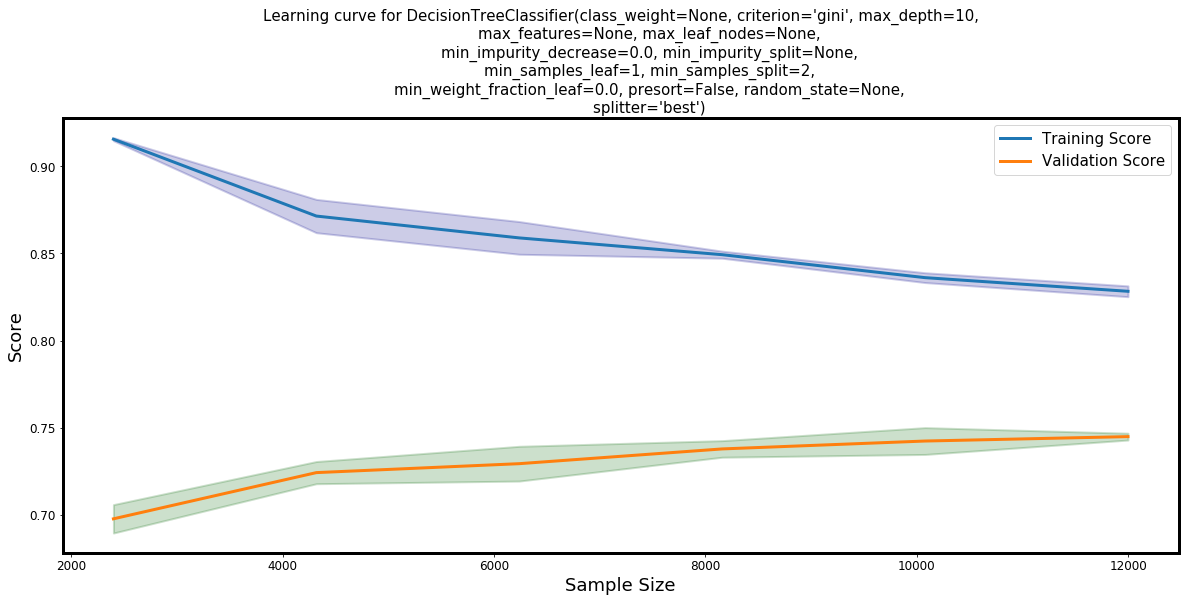

######################
Last Training Score : 1.0
Last Validation score : 0.8307994591554954
######################


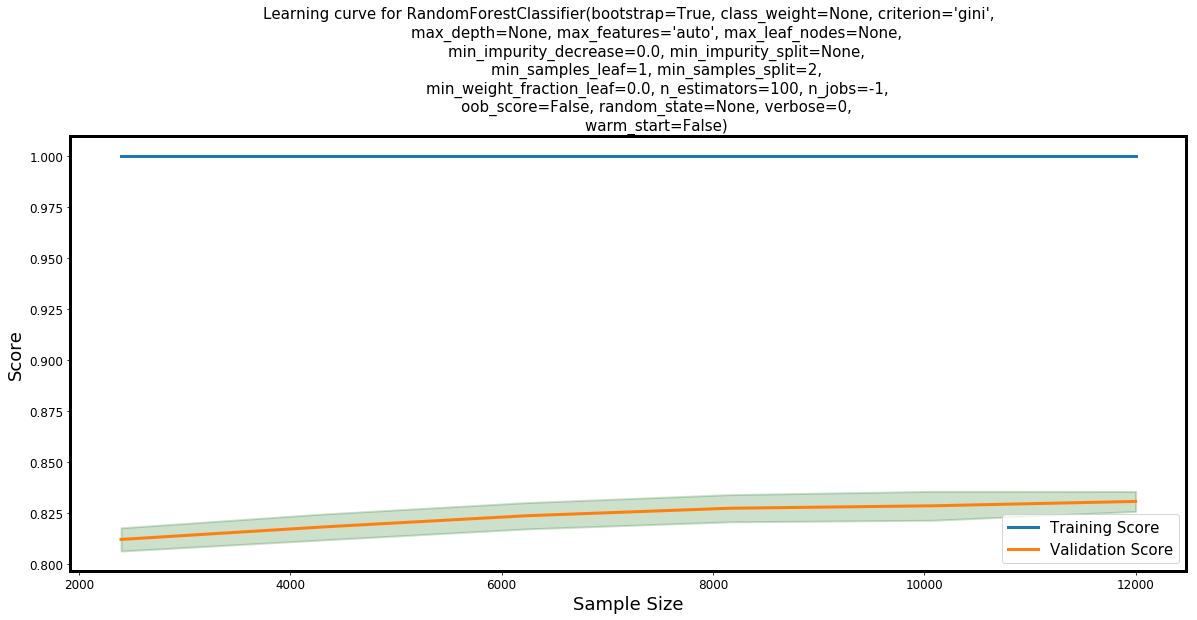

######################
Last Training Score : 1.0
Last Validation score : 0.8066664360444188
######################


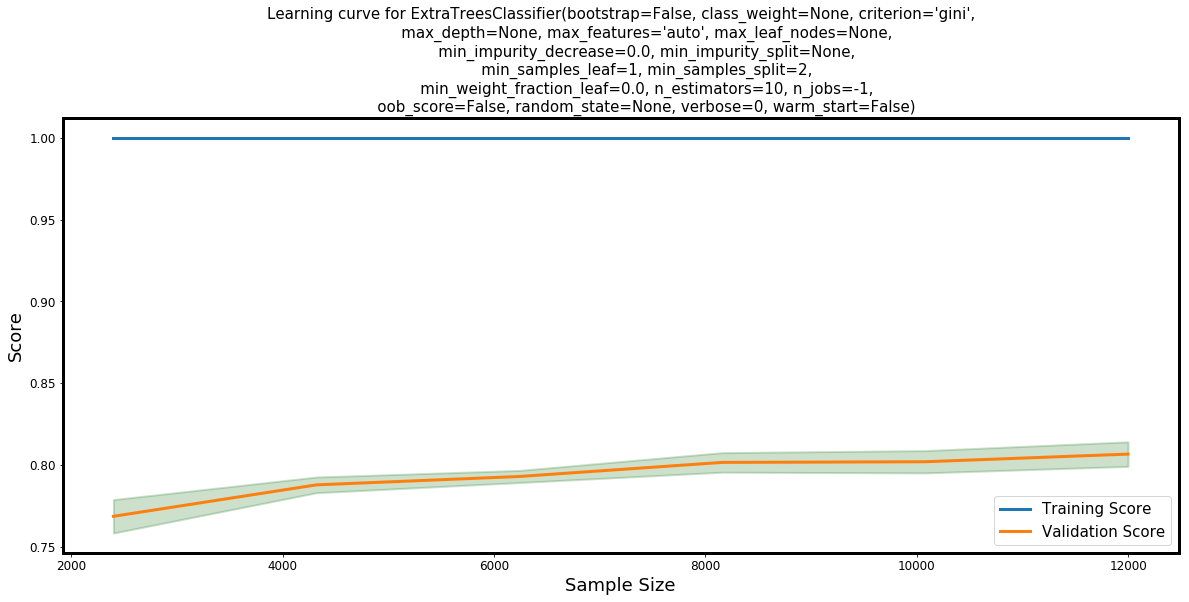

######################
Last Training Score : 0.8831735977998166
Last Validation score : 0.858866993918555
######################


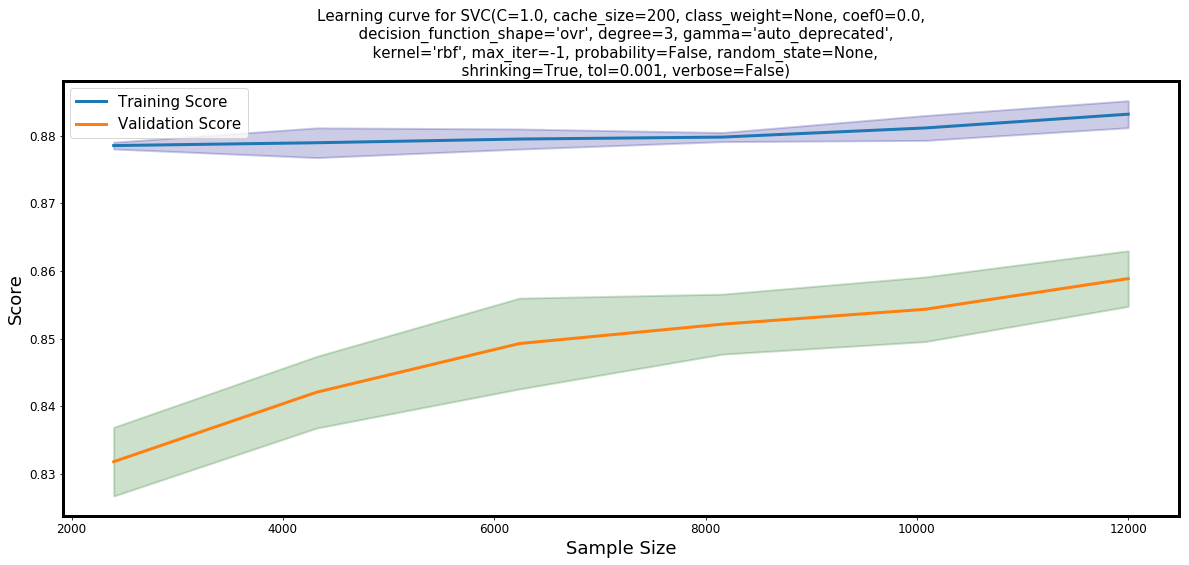

######################
Last Training Score : 0.8635552962746896
Last Validation score : 0.7761992342962112
######################


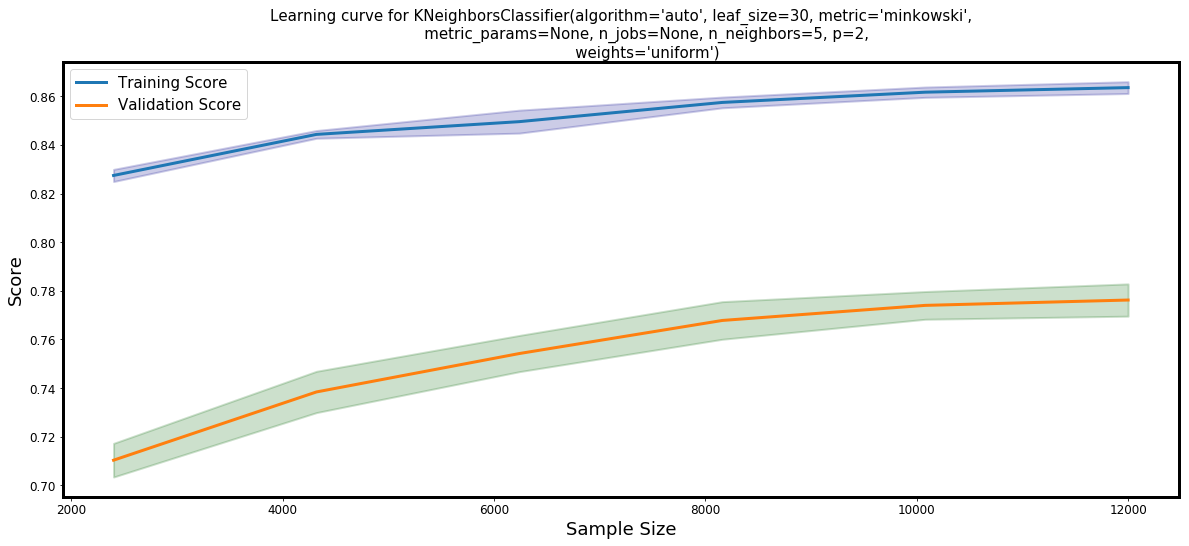

In [ ]:
train_sizes = list(np.linspace(0.2,1,6)) #for learning curve

for clf in clf_list:
  train_size, train_scores, validation_scores = my_learning_curve(estimator=clf, X=X_train, y=y_train, train_sizes=train_sizes, cv=5, n_jobs=-1, verbose=0)


According to Learning curves, the classifier made from Linear Regression and Ridge with polynomial transform, has a small variance and also a small bias. Other models such as SVC has a high bias and an small variance, which means more data will not enhance its performance. On the othe hand, classifiers and regressors based on tree, has a high variance but small biases, which means that if we provide more data for them, there will be an increase in their perfomance. With increasing data to 1 milion samples, the RandomForestClassifier Obtain a better score. Further increase of data samples will not increase the performance, although the variance remained larg yet.

### Validation curve

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0525s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   6 out of  40 | elapsed:    0.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  11 out of  40 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  16 out of  40 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  21 out of  40 | elapsed:    1.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


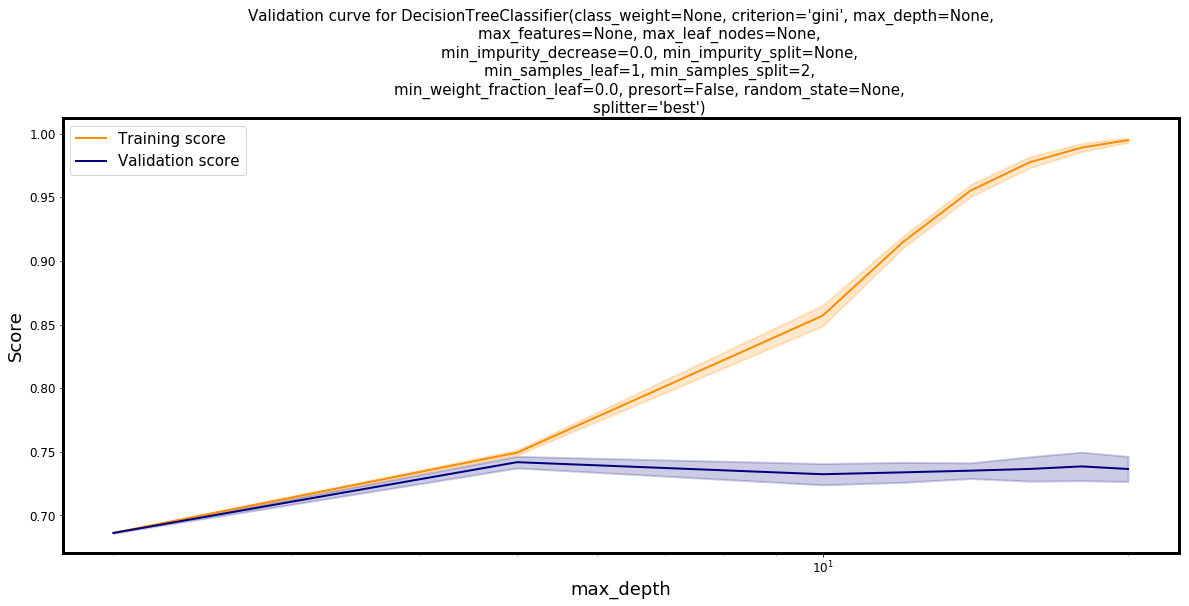

In [ ]:
### validation_curve
estimator = DecisionTreeClassifier()
param_name = 'max_depth'
param_range = [2,5,10,12,14,16,18,20]
train_scores, valid_scores = my_validation_curve(estimator,param_name,param_range,X_train,y_train,cv=5)

## NN

In [ ]:

### define model
model_name = 'B' # model name
model_NN = tf.keras.models.Sequential()
##### reduced_x_train
# model_NN.add(tf.keras.layers.Dense(4, activation='linear'  ))

model_NN.add(tf.keras.layers.Dense(1024, activation='relu' , input_dim=X.shape[1]))
# model_NN.add(tf.keras.layers.Dropout(0.25))

model_NN.add(tf.keras.layers.Dense(1024, activation='relu'  ))
# model_NN.add(tf.keras.layers.Dropout(0.25))

model_NN.add(tf.keras.layers.Dense(512, activation='relu' ))
# model_NN.add(tf.keras.layers.Dropout(0.25))

model_NN.add(tf.keras.layers.Dense(256, activation='relu' ))

model_NN.add(tf.keras.layers.Dense(128, activation='relu' ))
# model_NN.add(tf.keras.layers.Dropout(0.25))

# model_NN.add(tf.keras.layers.Dense(4000, activation='relu' ))
# model_NN.add(tf.keras.layers.Dense(50, activation='relu'  ))
# model_NN.add(tf.keras.layers.Dropout(0.2))

model_NN.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# tf.keras.layers.Flatten #conv2d
## compile model

model_NN.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])


# with open('model_{}_summary.txt'.format(model_name), 'w') as f:
#     with redirect_stdout(f):
#         model_NN.summary()
model_NN.summary()

NameError: ignored

In [ ]:
### Train
eta=0.0001
optimizer = tf.keras.optimizers.Adam(lr=eta)

model_NN.optimizer = optimizer

batch_size = 40960 #32 , 64:0.718 ,128: , 256:0.692 , 512: , 1024: , 2*1024: , 4*1024: 0.654 , 8*1024: 0.648 , 16*1024:0.603
print(batch_size)
#set early stopping monitor so the model stops training when it won't improve anymore #batch_itr*itr
#early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=10)
net = 'A'
#saves the model weights after each epoch if the validation loss decreased
#checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights_{}_net_{}.hdf5'.format(model_name,net), verbose=1, save_best_only=True)

#train model
model_NN.fit(X_train,y_train, epochs=10  , validation_split=0.1   , batch_size = batch_size )#,callbacks=[checkpointer]) #, callbacks=[early_stopping_monitor, checkpointer]

40960
Train on 4275000 samples, validate on 475000 samples
Epoch 1/10
4275000/4275000 [==============================] - 9s 2us/sample - loss: 0.5350 - acc: 0.6977 - val_loss: 0.4105 - val_acc: 0.8018
Epoch 2/10
4275000/4275000 [==============================] - 9s 2us/sample - loss: 0.2819 - acc: 0.8772 - val_loss: 0.2176 - val_acc: 0.9072
Epoch 3/10
4275000/4275000 [==============================] - 9s 2us/sample - loss: 0.1961 - acc: 0.9150 - val_loss: 0.1769 - val_acc: 0.9236
Epoch 4/10
4275000/4275000 [==============================] - 9s 2us/sample - loss: 0.1678 - acc: 0.9268 - val_loss: 0.1572 - val_acc: 0.9320
Epoch 5/10
4275000/4275000 [==============================] - 9s 2us/sample - loss: 0.1503 - acc: 0.9346 - val_loss: 0.1431 - val_acc: 0.9376
Epoch 6/10
4275000/4275000 [==============================] - 9s 2us/sample - loss: 0.1398 - acc: 0.9392 - val_loss: 0.1348 - val_acc: 0.9417
Epoch 7/10
4275000/4275000 [==============================] - 9s 2us/sample - loss: 0.130

In [ ]:
## Evaluate
load_net = 'A'
# model_NN.load_weights('weights_{}_net_{}.hdf5'.format(model_name,load_net))
model_NN.evaluate(X_test+0.04*np.random.rand(),y_test)

250000/250000 [==============================] - 13s 51us/sample - loss: 0.1154 - acc: 0.9498


[0.11540607663714886, 0.949776]

## NN Auto encoder

In [ ]:

### define model_auto
model_name = 'B' # model name
model_auto = tf.keras.models.Sequential()
##### reduced_x_train
# model_auto.add(tf.keras.layers.Dense(5, activation='linear' , input_dim=X.shape[1] ))

model_auto.add(tf.keras.layers.Dense(1024, activation='linear' ,input_dim=15))
# model_auto.add(tf.keras.layers.Dropout(0.25))

model_auto.add(tf.keras.layers.Dense(512, activation='relu'  ))
# model_auto.add(tf.keras.layers.Dropout(0.25))

model_auto.add(tf.keras.layers.Dense(64, activation='relu' ))
# model_auto.add(tf.keras.layers.Dropout(0.25))

model_auto.add(tf.keras.layers.Dense(16, activation='relu' ))
# model_auto.add(tf.keras.layers.Dropout(0.25))

model_auto.add(tf.keras.layers.Dense(8, activation='relu' ))
# model_auto.add(tf.keras.layers.Dropout(0.25))

model_auto.add(tf.keras.layers.Dense(2, activation='relu' ))
# model_auto.add(tf.keras.layers.Dropout(0.25))


model_auto.add(tf.keras.layers.Dense(8, activation='relu' ))
# model_auto.add(tf.keras.layers.Dropout(0.25))


model_auto.add(tf.keras.layers.Dense(16, activation='relu' ))
# model_auto.add(tf.keras.layers.Dropout(0.25))

model_auto.add(tf.keras.layers.Dense(64, activation='relu' ))
# model_auto.add(tf.keras.layers.Dropout(0.25))

model_auto.add(tf.keras.layers.Dense(512, activation='relu' ))
# model_auto.add(tf.keras.layers.Dropout(0.25))



# model_auto.add(tf.keras.layers.Dense(4000, activation='relu' ))
# model_auto.add(tf.keras.layers.Dense(50, activation='relu'  ))
# model_auto.add(tf.keras.layers.Dropout(0.2))

model_auto.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# tf.keras.layers.Flatten #conv2d
## compile model_auto

model_auto.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])


model_auto.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              16384     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (De

In [ ]:
batch_size = 4096 #32 , 64:0.718 ,128: , 256:0.692 , 512: , 1024: , 2*1024: , 4*1024: 0.654 , 8*1024: 0.648 , 16*1024:0.603
print(batch_size)
#set early stopping monitor so the model_auto stops training when it won't improve anymore #batch_itr*itr
#early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=10)

#train model_auto
model_auto.fit(X_train,y_train, epochs=10  , validation_split=0.1   , batch_size = batch_size )#,callbacks=[checkpointer]) #, callbacks=[early_stopping_monitor, checkpointer]

4096
Train on 4275000 samples, validate on 475000 samples
Epoch 1/10
4275000/4275000 [==============================] - 17s 4us/sample - loss: 0.0589 - acc: 0.9749 - val_loss: 0.0693 - val_acc: 0.9701
Epoch 2/10
4275000/4275000 [==============================] - 17s 4us/sample - loss: 0.0578 - acc: 0.9754 - val_loss: 0.0634 - val_acc: 0.9728
Epoch 3/10
4275000/4275000 [==============================] - 17s 4us/sample - loss: 0.0568 - acc: 0.9759 - val_loss: 0.0636 - val_acc: 0.9726
Epoch 4/10
4275000/4275000 [==============================] - 17s 4us/sample - loss: 0.0556 - acc: 0.9764 - val_loss: 0.0586 - val_acc: 0.9747
Epoch 5/10
4275000/4275000 [==============================] - 17s 4us/sample - loss: 0.0548 - acc: 0.9767 - val_loss: 0.0597 - val_acc: 0.9746
Epoch 6/10
4275000/4275000 [==============================] - 17s 4us/sample - loss: 0.0542 - acc: 0.9769 - val_loss: 0.0588 - val_acc: 0.9749
Epoch 7/10
4275000/4275000 [==============================] - 17s 4us/sample - loss:

In [ ]:
#@title Confusion matrix
model_auto.predict(dd.values)
dd=gen_sep(1000)
xx=np.concatenate((X_test,X_train[:750000]),axis=0)
yy=np.concatenate((y_test,y_train[:750000]),axis=0)
X_test.shape
Xp=(model_auto.predict(xx) > 0.5 )*1
Xp.shape
sk.metrics.confusion_matrix(yy,Xp)

## NN_linear

In [ ]:

### define model
model_name = 'B' # model name
model_lin = tf.keras.models.Sequential()
##### reduced_x_train
# model_lin.add(tf.keras.layers.Dense(5, activation='linear' , input_dim=X.shape[1] ))

model_lin.add(tf.keras.layers.Dense(15, activation='linear' ,input_dim=X.shape[1]))
# model_lin.add(tf.keras.layers.Dropout(0.25))

model_lin.add(tf.keras.layers.Dense(1024, activation='relu'  ))
# model_lin.add(tf.keras.layers.Dropout(0.25))

model_lin.add(tf.keras.layers.Dense(1024, activation='relu' ))
# model_lin.add(tf.keras.layers.Dropout(0.25))

model_lin.add(tf.keras.layers.Dense(512, activation='relu' ))
# model_lin.add(tf.keras.layers.Dropout(0.25))

model_lin.add(tf.keras.layers.Dense(256, activation='relu' ))
# model_lin.add(tf.keras.layers.Dropout(0.25))

model_lin.add(tf.keras.layers.Dense(128, activation='relu' ))
# model_lin.add(tf.keras.layers.Dropout(0.25))


# model_lin.add(tf.keras.layers.Dense(4000, activation='relu' ))
# model_lin.add(tf.keras.layers.Dense(50, activation='relu'  ))
# model_lin.add(tf.keras.layers.Dropout(0.2))

model_lin.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# tf.keras.layers.Flatten #conv2d
## compile model

model_lin.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])


model_lin.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_99 (Dense)             (None, 1024)              16384     
_________________________________________________________________
dense_100 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_101 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_102 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_103 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_104 (Dense)            (None, 1)               

In [ ]:
### Train
eta=0.0001
optimizer = tf.keras.optimizers.Adam(lr=eta)

model_lin.optimizer = optimizer
batch_size = 512 #32 , 64:0.718 ,128: , 256:0.692 , 512: , 1024: , 2*1024: , 4*1024: 0.654 , 8*1024: 0.648 , 16*1024:0.603
print(batch_size)
# set early stopping monitor so the model stops training when it won't improve anymore #batch_itr*itr
early_stopping_monitord = tf.keras.callbacks.EarlyStopping(patience=4)

#train model
history=model_lin.fit(X_train,y_train, epochs=20  , validation_split=0.1   , batch_size = batch_size , verbose=1)

512
Train on 4275000 samples, validate on 475000 samples
Epoch 1/20
4275000/4275000 [==============================] - 36s 8us/sample - loss: 0.1744 - acc: 0.9211 - val_loss: 0.0938 - val_acc: 0.9589
Epoch 2/20
4275000/4275000 [==============================] - 35s 8us/sample - loss: 0.0738 - acc: 0.9678 - val_loss: 0.0626 - val_acc: 0.9730
Epoch 3/20
4275000/4275000 [==============================] - 35s 8us/sample - loss: 0.0575 - acc: 0.9750 - val_loss: 0.0563 - val_acc: 0.9758
Epoch 4/20
4275000/4275000 [==============================] - 36s 8us/sample - loss: 0.0497 - acc: 0.9786 - val_loss: 0.0524 - val_acc: 0.9767
Epoch 5/20
4275000/4275000 [==============================] - 36s 8us/sample - loss: 0.0449 - acc: 0.9808 - val_loss: 0.0476 - val_acc: 0.9796
Epoch 6/20
4275000/4275000 [==============================] - 35s 8us/sample - loss: 0.0415 - acc: 0.9824 - val_loss: 0.0453 - val_acc: 0.9806
Epoch 7/20
4275000/4275000 [==============================] - 35s 8us/sample - loss: 

In [ ]:
### Evaluate
load_net = 'A'
# model_lin.load_weights('weights_{}_net_{}.hdf5'.format(model_name,load_net))
model_lin.evaluate(X_test,y_test)

250000/250000 [==============================] - 11s 42us/sample - loss: 0.6971 - acc: 0.3966


[0.6970701071472168, 0.396608]

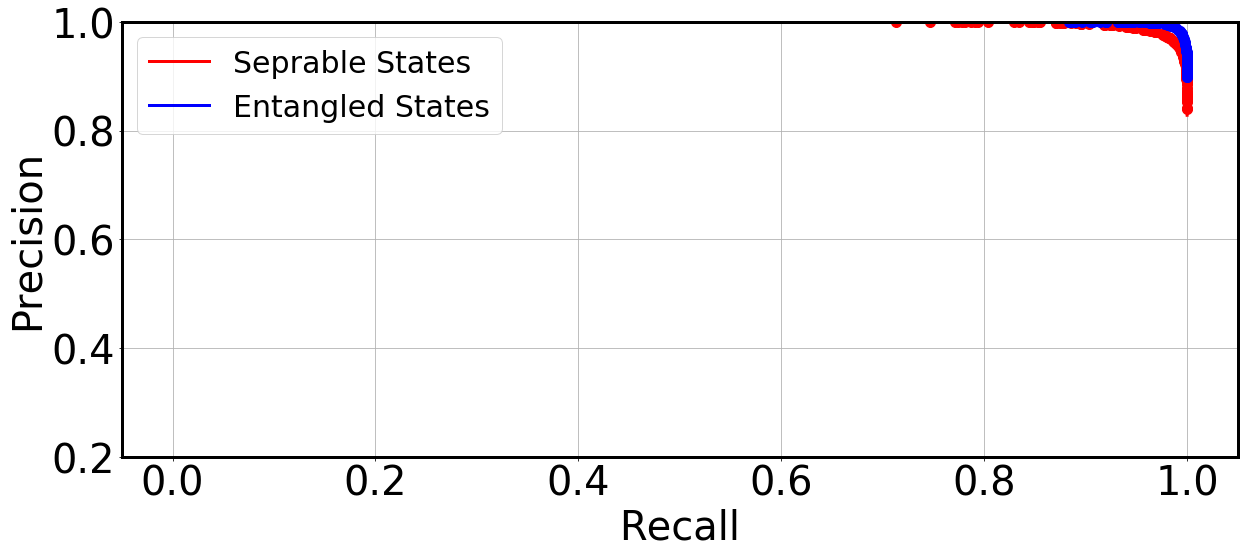

In [ ]:
#@title Precision Recall
decision_values_NN = model_lin.predict(X_test)
precision0, recall0, thresholds0 = sk.metrics.precision_recall_curve(y_test, 1-decision_values_NN,pos_label=0)
precision1, recall1, thresholds1 = sk.metrics.precision_recall_curve(y_test, decision_values_NN,pos_label=1)
np.save("pre_rec01",precision0 )
np.save("pre_rec02",recall0 )
np.save("pre_rec03", precision1)
np.save("pre_rec04",recall1)
plt.rc('font', size=180)          # controls default text sizes
plt.rc('axes', titlesize=40)
#plt.title('Precision-Recall Curve')
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels

plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size


plt.grid()
plt.ylim(0.2,1)
np.random.seed(0)
x0 = np.random.choice(recall0,size = 100)
np.random.seed(0)
y0 = np.random.choice(precision0,size = 100)
np.random.seed(5)
x1 = np.random.choice(recall1,size = 100)
np.random.seed(5)
y1 = np.random.choice(precision1,size = 100)
plt.plot(recall0,precision0,c='r',label='Seprable States')
plt.plot(recall1,precision1,c='b',label='Entangled States')
plt.plot(x0,y0,linewidth = 0,marker = ".",markersize = 20, c='r')
plt.plot(x1,y1,linewidth = 0,marker = ".",markersize = 20,c='b')
plt.legend()
plt.show()

In [ ]:
#@title threshold needed

p=1
for i in range(len(precision1)):
  if precision1[i]>=p:
    print('precison : ',p)
    print('recall : ',recall1[i])
    thresh = thresholds1[i]
    print('threshold : ',thresh)
    break

precison :  1
recall :  0.9042704355809208
threshold :  0.9999138


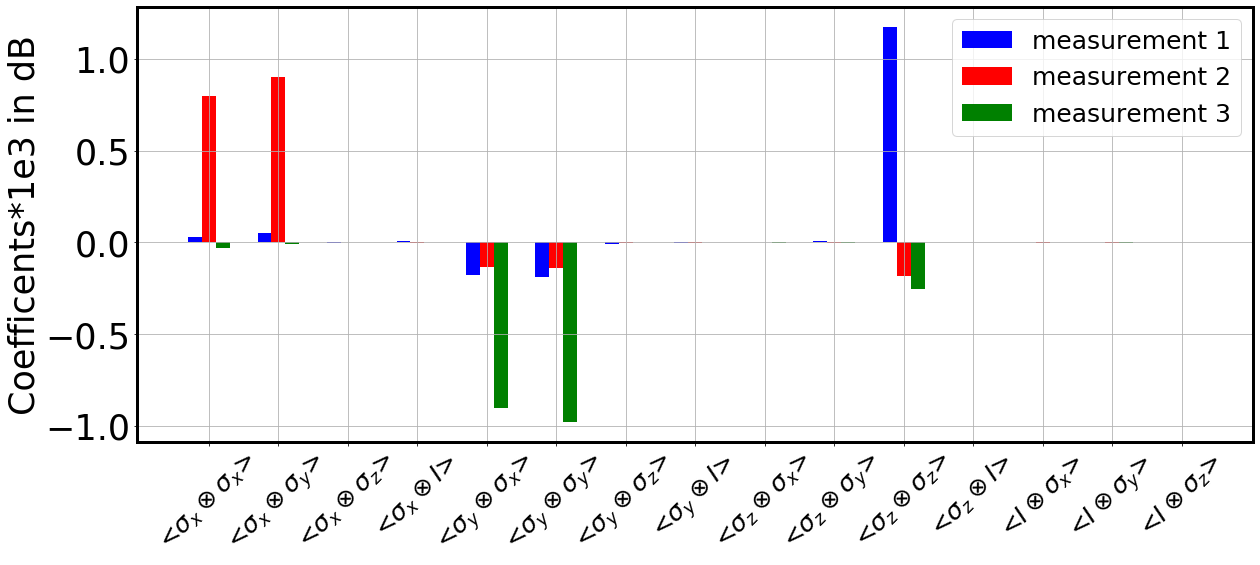

In [ ]:
#@title First Layer Coefs
############################
##   zarayeb laye aval    ##
############################
a=model_lin.layers[0].get_weights()[0]
aa=[r'<$\sigma_x \otimes \sigma_x$>',
 r'<$\sigma_x \otimes \sigma_y$>',
 r'<$\sigma_x \otimes \sigma_z$>',
 r'<$\sigma_x \otimes I$>',
 r'<$\sigma_y \otimes \sigma_x$>',
 r'<$\sigma_y \otimes \sigma_y$>',
 r'<$\sigma_y \otimes \sigma_z$>',
 r'<$\sigma_y \otimes I$>',
 r'<$\sigma_z \otimes \sigma_x$>',
 r'<$\sigma_z \otimes \sigma_y$>',
 r'<$\sigma_z \otimes \sigma_z$>',
 r'<$\sigma_z \otimes I$>',
 r'<$I \otimes \sigma_x$>',
 r'<$I \otimes \sigma_y$>',
 r'<$I \otimes \sigma_z$>']

x = np.arange(15)

#y = 30+10*np.log10(np.abs(a[:,0]))
#z = 30+10*np.log10(np.abs(a[:,1]))
#k = 30+10*np.log10(np.abs(a[:,2]))
y = a[:,0]
z = a[:,1]
k = a[:,2]


ax = plt.subplot(111)
m1=ax.bar(x-0.2, y, width=0.2, color='blue', align='center')
m2=ax.bar(x, z, width=0.2, color='red', align='center')
m3=ax.bar(x+0.2, k, width=0.2, color='green', align='center')
ax.set_xticks(x)
ax.set_xticklabels(tuple(aa))
ax.legend((m1[0],m2[0],m3[0]),('measurement 1','measurement 2','measurement 3'))
plt.xticks(rotation=45)
plt.ylabel('Coefficents*1e3 in dB')
plt.rc('font', size=180)          # controls default text sizes
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=35)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=35)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size
#plt.legend()

#plt.title('Coefficients of the first layer')
plt.grid()

plt.show()

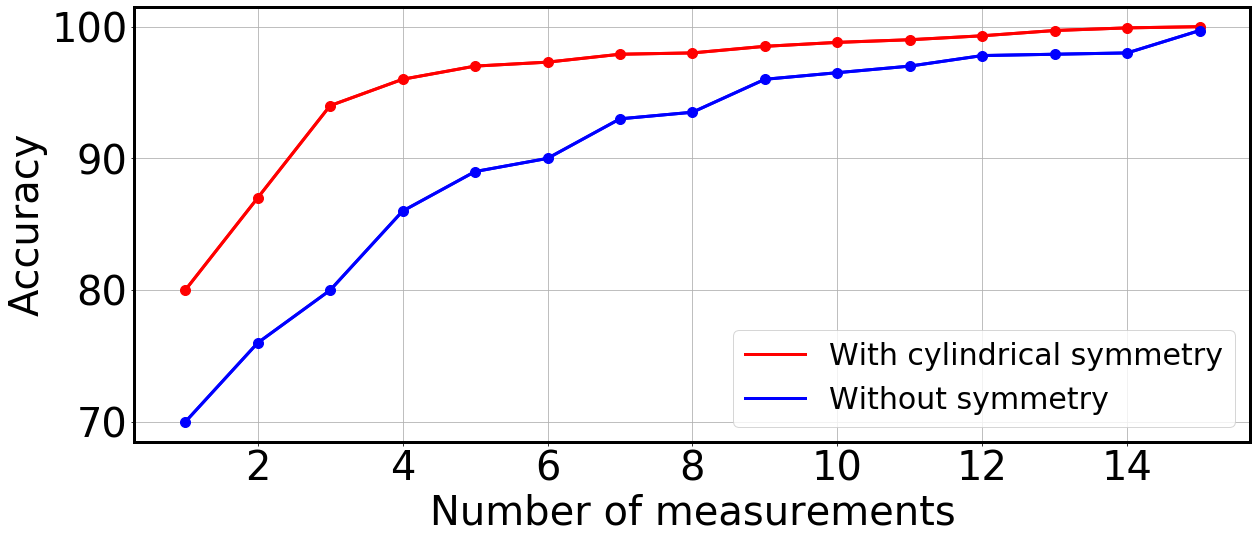

In [ ]:
#@title accuracy-n

y0=np.array([80,87,94,96,97,97.3,97.9,98,98.5,98.8,99,99.3,99.7,99.9,99.99])
y1=np.array([70,76,80,86,89,90,93,93.5,96,96.5,97,97.8,97.9,98,99.7])
n=np.array(range(1,16))


plt.rc('font', size=180)          # controls default text sizes
plt.rc('axes', titlesize=40)
#plt.title('Accuracy of different number of linear measurements')
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.xlabel('Number of measurements')
plt.ylabel('Accuracy')
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels

plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size


plt.grid()


plt.plot(n,y0,c='r',label='With cylindrical symmetry')
plt.plot(n,y1,c='b',label='Without symmetry')
plt.plot(n,y0,c='r',marker = ".",markersize = 20)
plt.plot(n,y1,c='b',marker = ".",markersize =20)
plt.legend()
plt.show()

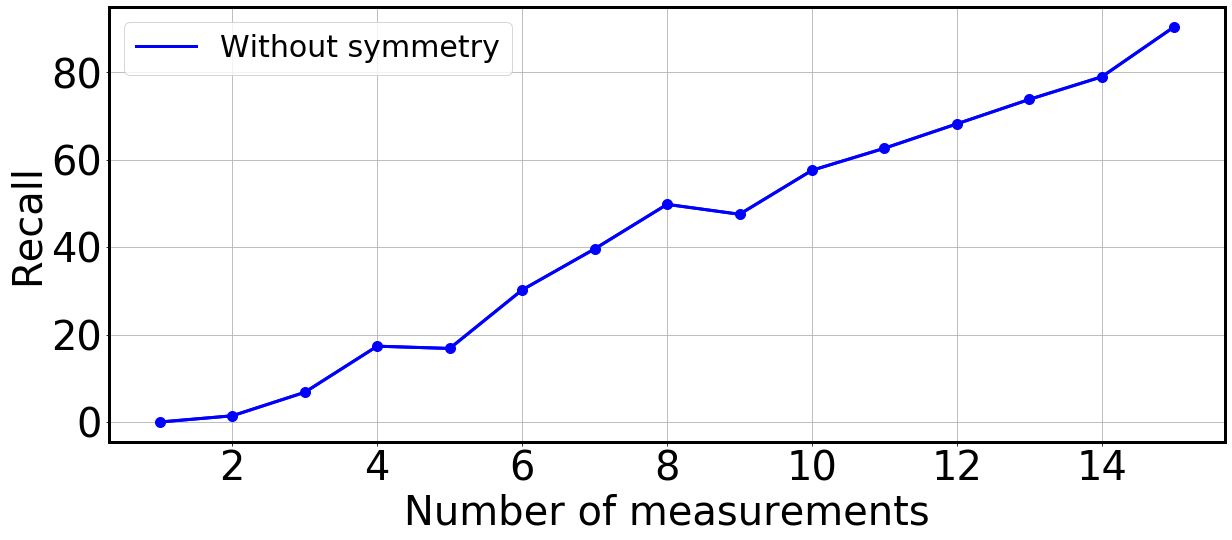

In [ ]:
#@title recall-n

recall_em=np.array([4.0932e-3,1.432,6.80,17.35,16.83,30.214,39.595,49.787,47.52,57.5753,62.62,68.2,73.80,78.97,90.42])
n=np.array(range(1,16))

plt.rc('font', size=180)          # controls default text sizes
plt.rc('axes', titlesize=40)
#plt.title('Accuracy of different number of linear measurements')
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.xlabel('Number of measurements')
plt.ylabel('Recall')
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels

plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size


plt.grid()


#plt.plot(n,y0,c='r',label='With cylindrical symmetry')
plt.plot(n,recall_em,c='b',label='Without symmetry')
#plt.plot(n,y0,c='r',marker = ".",markersize = 20)
plt.plot(n,recall_em,c='b',marker = ".",markersize =20)
plt.legend()
plt.show()

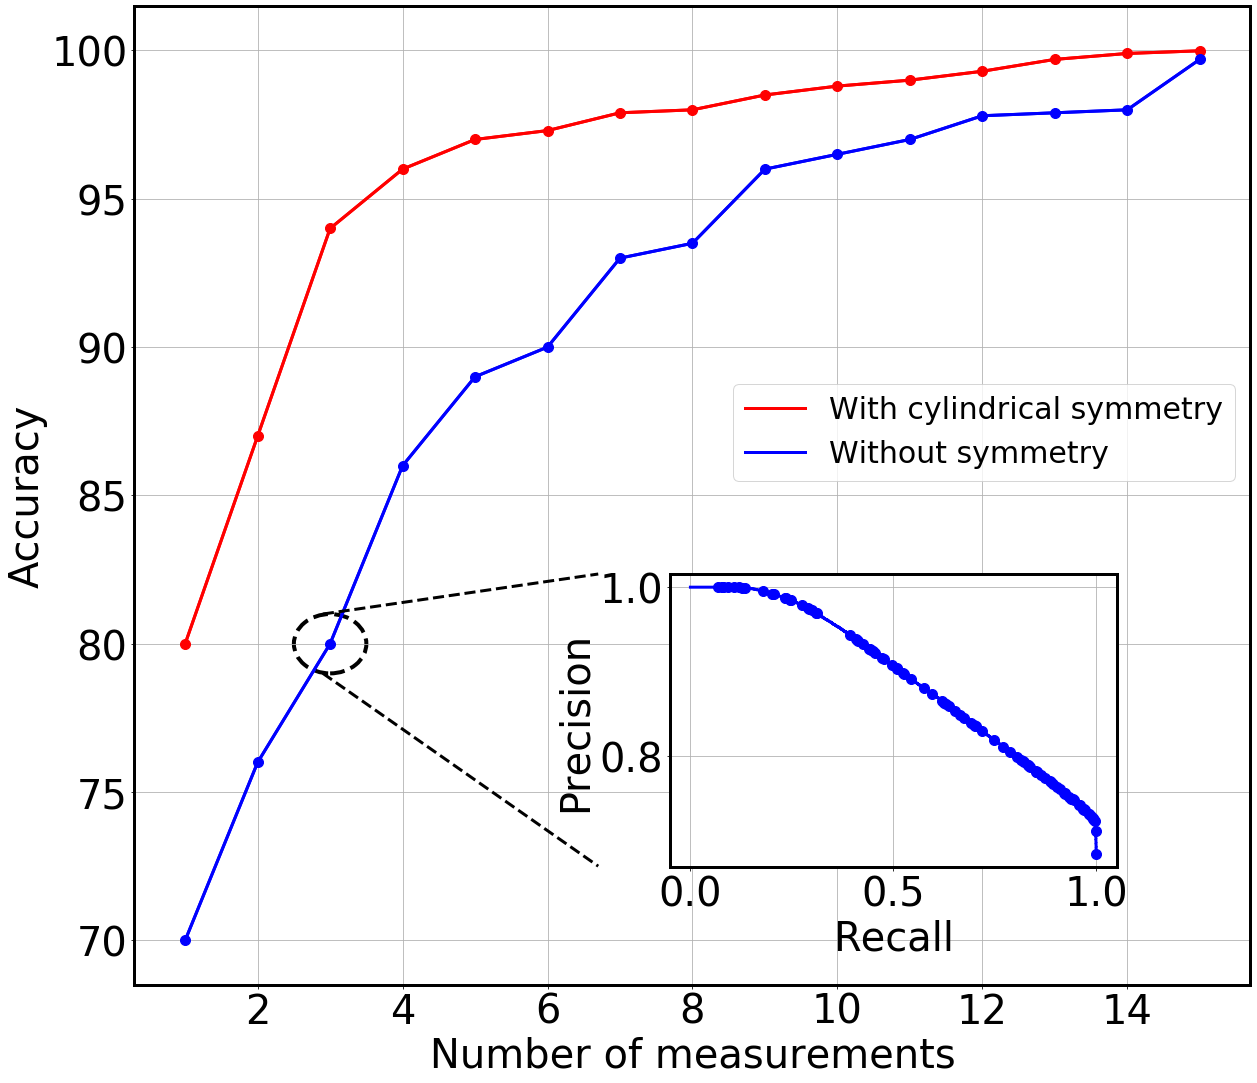

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.patches import Ellipse
fig, ax1 = plt.subplots(figsize=(20, 18))
#ax1.rc('font', size=180)          # controls default text sizes
#ax1.rc('axes', titlesize=40)
#plt.title('Accuracy of different number of linear measurements')
#ax1.rc('axes', labelsize=40)    # fontsize of the x and y labels
ax1.set_xlabel('Number of measurements')
ax1.set_ylabel('Accuracy')
#ax1.rc('xtick', labelsize=40)    # fontsize of the tick labels
#ax1.rc('ytick', labelsize=40)    # fontsize of the tick labels

#ax1.rc('legend', fontsize=30)    # legend fontsize
#ax1.rc('figure', titlesize=18)  # fontsize of the figure title
#ax1.rc('axes', linewidth = 3 )
#ax1.rc('lines', linewidth = 3 )
#ax1.rc('lines', markersize = 5 )
#ax1.rc('figure', figsize=(20,8) )         # Image size


ax1.grid()


ax1.plot(n,y0,c='r',label='With cylindrical symmetry')
ax1.plot(n,y1,c='b',label='Without symmetry')
ax1.plot(n,y0,c='r',marker = ".",markersize = 20)
ax1.plot(n,y1,c='b',marker = ".",markersize =20)
ax1.legend(loc =4 ,  bbox_to_anchor=(1, 0.5))
# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.48,0.12,0.4,0.3])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
#mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')
np.random.seed(5)
x11 = np.random.choice(recall1,size = 100)
np.random.seed(5)
y11 = np.random.choice(precision1,size = 100)
ax2.plot(recall1,precision1,c='b',label='Entangled States')
ax2.plot(x11,y11,linewidth = 0,marker = ".",markersize = 20, c='b')
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")
# The data: only display for low temperature in the inset figure.
#ax2.legend(loc=0)
circle2 = Ellipse(xy=(3, 80), width=1, height=2, edgecolor='k', fc='None', lw=4,ls="--")
#circle2 = Ellipse((3, 80), 0.5, color='b', fill=False)
ax1.add_patch(circle2)
rez = np.array((2.9 , 6.7))
rez1= np.array ((81,82.35))
ax1.plot(rez , rez1, c = 'k', linestyle="--")
rez2 = np.array((2.9 , 6.7))
rez21= np.array ((79,72.5))
ax1.plot(rez2 , rez21,c = 'k',linestyle='--')


ax2.grid()


# Some ad hoc tweaks.
#ax1.set_ylim(0,26)
#ax2.set_yticks(np.arange(0,2,0.4))
#ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
#ax2.tick_params(axis='x', which='major', pad=8)

plt.show()

## noise

250000/250000 [==============================] - 14s 57us/sample - loss: 1.2935 - acc: 0.8303


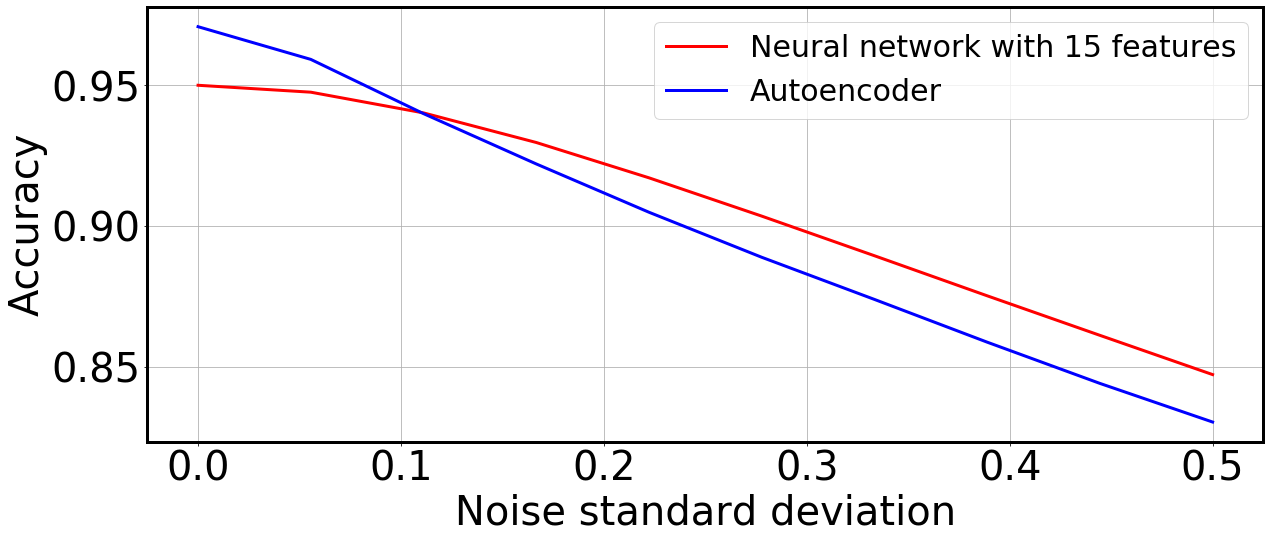

In [ ]:
#@title noise-guassian
load_net = 'A'
# model.load_weights('weights_{}_net_{}.hdf5'.format(model_name,load_net))

noise = np.random.rand(*X_test.shape)
sigma_list = np.linspace(0,0.5,10)
res0 = [model_NN.evaluate(X_test+noise*sigma,y_test)[1] for sigma in sigma_list]
res1 = [model_auto.evaluate(X_test+noise*sigma,y_test)[1] for sigma in sigma_list]


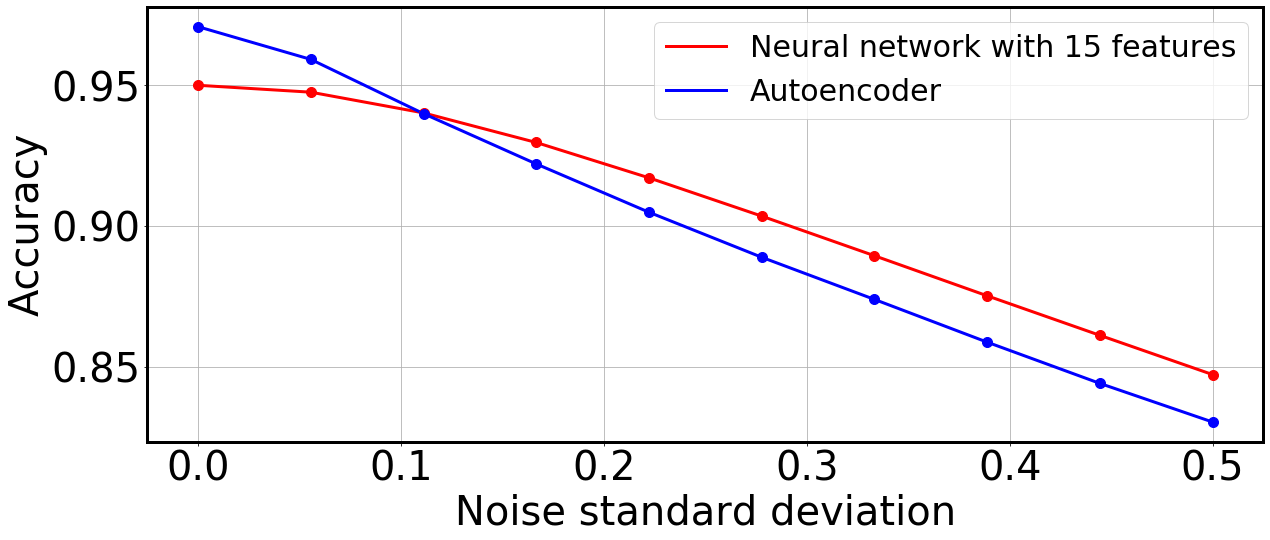

In [ ]:
np.save("ACC_Noise01" , sigma_list)
np.save("ACC_Noise02" , res0)
np.save("ACC_Noise03" , res1)

plt.plot(sigma_list,res0,c='r',label='Neural network with 15 features')
plt.plot(sigma_list,res1,c='b',label='Autoencoder')
plt.plot(sigma_list,res0,c='r', linewidth = 0 , marker = "." , markersize = 20 )
plt.plot(sigma_list,res1,c='b', linewidth = 0 , marker = "." , markersize = 20 )

plt.rc('font', size=180)          # controls default text sizes
plt.rc('axes', titlesize=40)
#plt.title('Accuracy in case of Guassian noise with different standard deviation')
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.xlabel('Noise standard deviation')
plt.ylabel('Accuracy')
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 3 )
plt.rc('lines', markersize = 5 )
plt.rc('figure', figsize=(20,8) )         # Image size
plt.grid()

plt.legend()
plt.show()

# Other

## feature_selection / feature importance

In [ ]:
plt_title = 'Feature Importance for {}'.format('Random Forest Classifier')
x_label = 'Feature'
y_label = 'Importance'
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
est = RandomForestClassifier(n_jobs=-1,verbose=10)
est.fit(X,y)




feature_importances = est.feature_importances_
ax.bar(  data.columns , feature_importances )

# feature_importances = opt_estimator.coef_
# plt.scatter(  np.arange(feature_importances.size).reshape(1,-1) , feature_importances  )

plt.show()

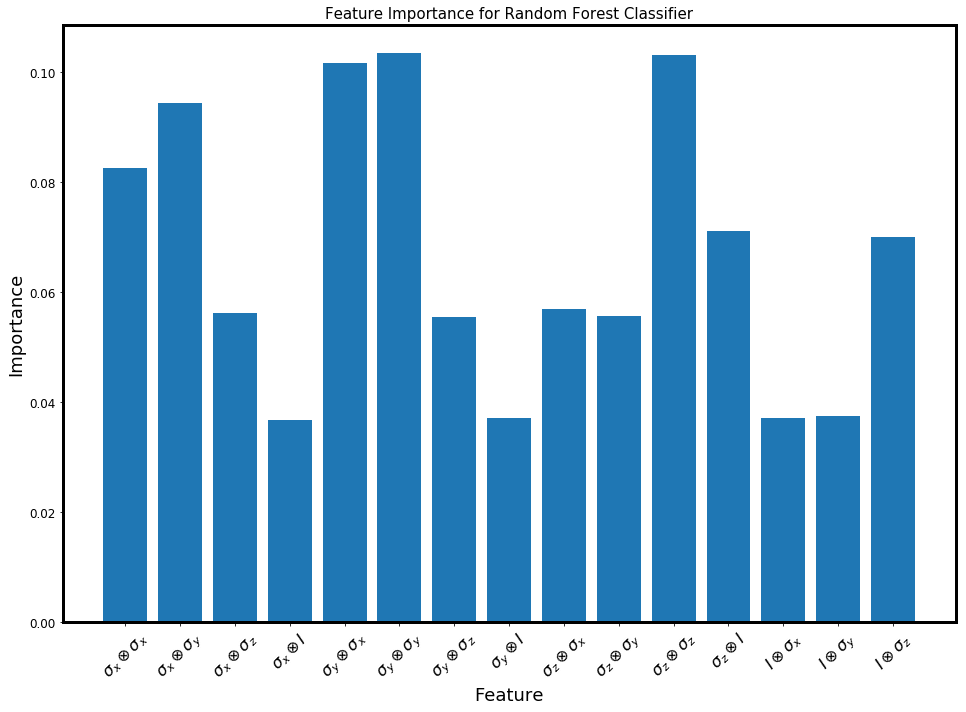

In [ ]:
plt_title = 'Feature Importance for {}'.format('Random Forest Classifier')
x_label = 'Feature'
y_label = 'Importance'
plt.rc('xtick', labelsize=16)

fig = plt.figure(figsize=(16,11))
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
plt.xticks(rotation=45)
plt.bar(  aa,feature_importances  )
plt.show()

In [ ]:
aa=[r'$\sigma_x \otimes \sigma_x$',
 r'$\sigma_x \otimes \sigma_y$',
 r'$\sigma_x \otimes \sigma_z$',
 r'$\sigma_x \otimes I$',
 r'$\sigma_y \otimes \sigma_x$',
 r'$\sigma_y \otimes \sigma_y$',
 r'$\sigma_y \otimes \sigma_z$',
 r'$\sigma_y \otimes I$',
 r'$\sigma_z \otimes \sigma_x$',
 r'$\sigma_z \otimes \sigma_y$',
 r'$\sigma_z \otimes \sigma_z$',
 r'$\sigma_z \otimes I$',
 r'$I \otimes \sigma_x$',
 r'$I \otimes \sigma_y$',
 r'$I \otimes \sigma_z$']

### manual feature reduction

In [ ]:
'''
Let's pick the first m more important features. 
'''
m=8
opt_estimator=RandomForestClassifier(n_estimators=100,verbose=10,n_jobs=-1)
index_imfr = ind#np.argsort( feature_importances   )[::-1][:m]

reduced_x_train = X_train[:,index_imfr ]
reduced_x_test = X_test[ :,index_imfr ]

opt_estimator.fit(reduced_x_train, y_train)
print('Score with data reduction is: {}'.format(  opt_estimator.score(reduced_x_test, y_test)  ))
print(index_imfr)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.6s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.5s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.4s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   43.1s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   56.6s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.0min


building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.3min


building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.8min


building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.2min


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    5.4s


Score with data reduction is: 0.77722
[0, 1, 4, 5, 10]


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.8s finished


### SelectFromModel

In [ ]:
'''
model = SelectFromModel(opt_estimator, threshold='median')
reduced_x_train = model.fit_transform(x_train,y_train)
print('{} feature selection: with {} features.'.format(estim,reduced_x_train.shape[1] ))

sm_scores = cross_val_score(opt_estimator,  reduced_x_train , y_train , cv=5, n_jobs=-1)
reduced_x_test = model.transform(x_test)

print('The cv scores are:\n {}'.format(sm_scores))
print('test score : {}'.format(opt_estimator.score(reduced_x_test,y_test)))
'''

### RFE

In [ ]:
rfe = RFE(estimator=opt_estimator, n_features_to_select=8, step=0.5, verbose=10)
rfe.fit(x_train, y_train)
# rfe.estimator_
reduced_x_train = rfe.transform(x_train)
reduced_x_test = rfe.transform(x_test)

print('{} feature selection: with {} features.'.format(estim,rfe.n_features_ ))

rfs_scores = cross_val_score(opt_estimator,  reduced_x_train , y_train , cv=5, n_jobs=-1,verbose=10)

print('The cv scores are:\n {}'.format(rfs_scores))
print('Test Score : {}'.format(rfe.estimator_.score(reduced_x_test,y_test)))

Fitting estimator with 15 features.
RandomForestClassifier feature selection: with 8 features.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   26.5s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s finished


The cv scores are:
 [0.82734915 0.82331802 0.822375   0.82352574 0.82308822]
Test Score : 0.8305
Test Score : 0.8314


[ True  True False False  True  True  True False False False  True  True
 False False  True]
[1 1 4 6 1 1 1 8 2 3 1 1 5 7 1]


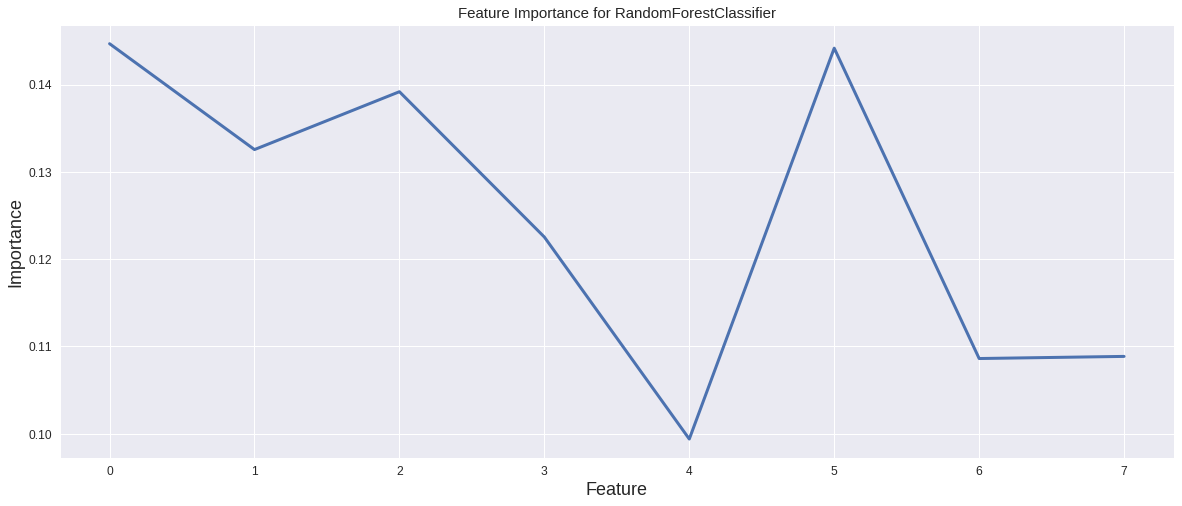

In [ ]:
plt_title = 'Feature Importance for {}'.format(estimator)
x_label = 'Feature'
y_label = 'Importance'
fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
feature_importances = rfe.estimator_.feature_importances_
ax.plot(  np.arange(feature_importances.size) , feature_importances  )
#print(rfe.support_)
print(rfe.ranking_)

### PCA

In [ ]:
pca = PCA()
X_train_red = pca.fit_transform(X_train)

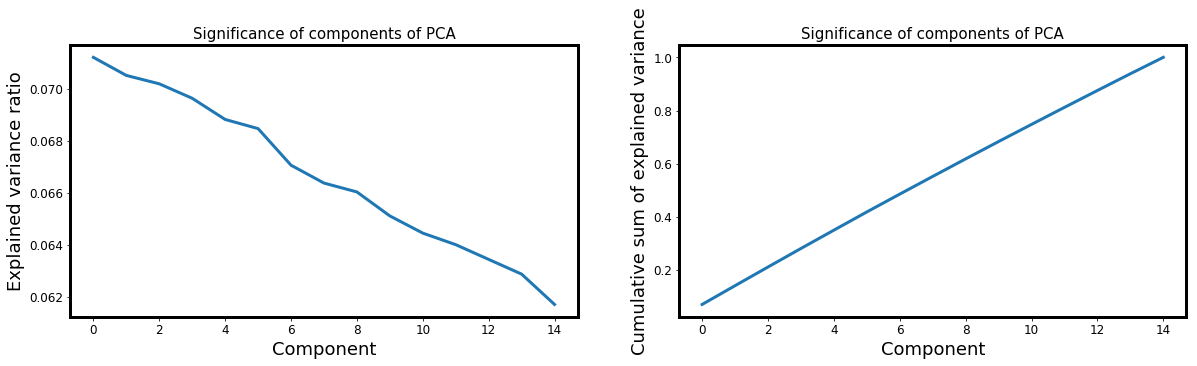

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1, title = 'Significance of components of PCA', xlabel='Component', ylabel='Explained variance ratio')
ax1.plot(pca.explained_variance_ratio_)
ax1 = fig.add_subplot(1,2,2, title = 'Significance of components of PCA', xlabel='Component', ylabel='Cumulative sum of explained variance')
ax1.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()

In [ ]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

                estimator  N_sample  poly_feature          scaler  fit_time  \
0  RandomForestClassifier     10000             0  StandardScaler   1.62691   

   score_time  test_score  train_score  
0    0.102501    0.746134          1.0  
----------------------------
##################################################################
Test Score on test set : 0.754
----------------------------
Confusion Matirix : 

[[ 337  447]
 [ 168 1548]]
----------------------------
              precision    recall  f1-score   support

           0       0.67      0.43      0.52       784
           1       0.78      0.90      0.83      1716

   micro avg       0.75      0.75      0.75      2500
   macro avg       0.72      0.67      0.68      2500
weighted avg       0.74      0.75      0.74      2500

----------------------------
AUC : 0.6659724204367061
----------------------------


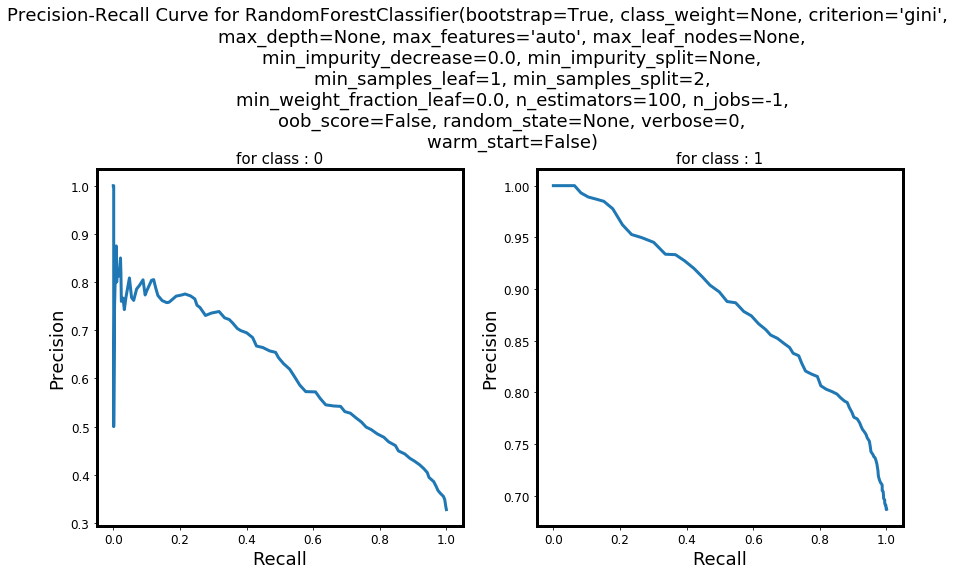

In [ ]:
clf_list = [
#   DummyClassifier(strategy='most_frequent'),
#   RidgeClassifier(),
#   SGDClassifier(),
#   GaussianNB(),
#   DecisionTreeClassifier(max_depth=10),
  RandomForestClassifier(n_estimators=100,n_jobs=-1),
#   ExtraTreesClassifier(n_jobs=-1),
#   SVC(), #O(N^2)
#   KNeighborsClassifier(), #O(N^2)
#   BaggingClassifier(),
#   GradientBoostingClassifier(),
#   AdaBoostClassifier()
]

reg_list=[
#     LinearRegression(),
#     Ridge(),
#     Lasso(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(n_estimators=100),
#     SVR(),
#     SVR(kernel='poly',degree=4),
#     KNeighborsRegressor()
]
##################################################################################

clf_reg_list = [my_clf_from_reg(regs) for regs in reg_list ]
table_clf=pd.DataFrame()

def reg_scoring(estimator,X,y): #for reg to clf
      return estimator.score(X,y<0)

if is_clf :
  scoring=None
else:
  scoring=reg_scoring
  


#with open('clf_analysis.txt', 'w') as f:
#    with redirect_stdout(f):
#        print('hi')

# for clf in clf_reg_list:

if not is_clf: clf_list = clf_reg_list

for clf in clf_list:
  
  info = pd.DataFrame()
  info['estimator'] =[str(clf).split('(')[0]]
  info['N_sample']= N_sample
  info['poly_feature']=poly_feature
  info['scaler']= scaler
  
  info_dict = cross_validate(clf,X_train_pca,y_train,scoring=scoring,cv=5,n_jobs=-1,verbose=0,return_train_score=True)
  info_mean = pd.DataFrame({key:[info_dict[key].mean()] for key in info_dict.keys()})
  
  info=pd.concat([info,info_mean],axis=1)
  
  print(info)
  table_clf=table_clf.append(info,ignore_index=True)
  
  clf.fit(X_train_pca,y_train)
  print('----------------------------')
  if not is_clf:
    y_testt = y_test<0
  else:
    y_testt = y_test
  my_clf_score_analyze(clf,X_test_pca,y_testt)
  precision, recall, thresholds = my_precision_recall_curve(clf,X_test_pca,y_testt)

In [ ]:
table_clf.to_csv('table_clf.csv',index=False)
table_clf

,estimator,N_sample,poly_feature,scaler,fit_time,score_time,test_score,train_score
0,RandomForestClassifier,10000,0,StandardScaler,1.62691,0.102501,0.746134,1.0


### Manifold

In [ ]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)
X_train_tsne , X_test_tsne , y_train , y_test= train_test_split(X,y)

/usr/local/lib/python3.6/dist-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/usr/local/lib/python3.6/dist-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


                estimator  N_sample  poly_feature          scaler  fit_time  \
0  RandomForestClassifier     10000             0  StandardScaler  1.852305   

   score_time  test_score  train_score  
0    0.102946    0.813467          1.0  
----------------------------
##################################################################
Test Score on test set : 0.8156
----------------------------
Confusion Matirix : 

[[ 421  401]
 [  60 1618]]
----------------------------
              precision    recall  f1-score   support

           0       0.88      0.51      0.65       822
           1       0.80      0.96      0.88      1678

   micro avg       0.82      0.82      0.82      2500
   macro avg       0.84      0.74      0.76      2500
weighted avg       0.83      0.82      0.80      2500

----------------------------
AUC : 0.7382042983623767
----------------------------


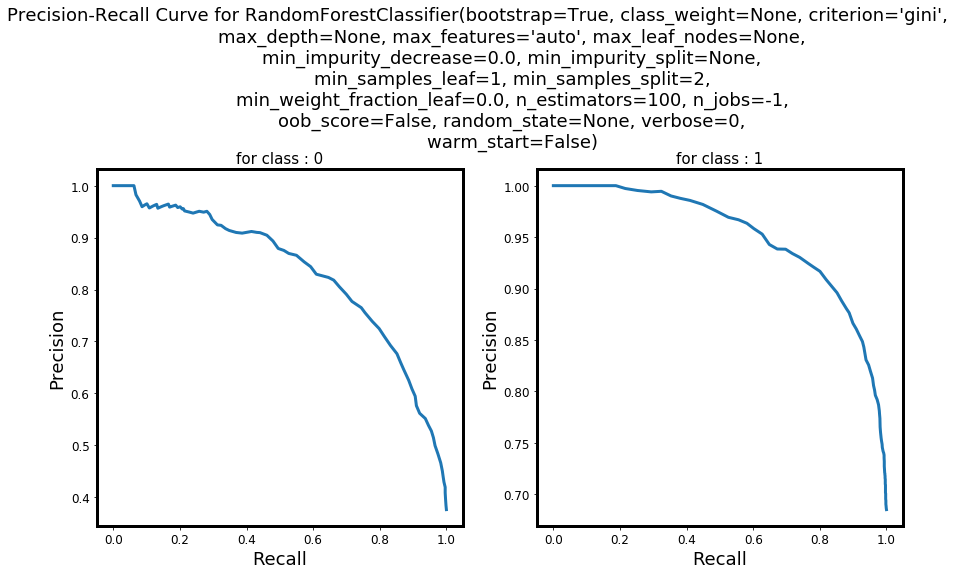

In [ ]:
clf_list = [
#   DummyClassifier(strategy='most_frequent'),
#   RidgeClassifier(),
#   SGDClassifier(),
#   GaussianNB(),
#   DecisionTreeClassifier(max_depth=10),
  RandomForestClassifier(n_estimators=100,n_jobs=-1),
#   ExtraTreesClassifier(n_jobs=-1),
#   SVC(), #O(N^2)
#   KNeighborsClassifier(), #O(N^2)
#   BaggingClassifier(),
#   GradientBoostingClassifier(),
#   AdaBoostClassifier()
]

reg_list=[
#     LinearRegression(),
#     Ridge(),
#     Lasso(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(n_estimators=100),
#     SVR(),
#     SVR(kernel='poly',degree=4),
#     KNeighborsRegressor()
]
##################################################################################

clf_reg_list = [my_clf_from_reg(regs) for regs in reg_list ]
table_clf=pd.DataFrame()

def reg_scoring(estimator,X,y): #for reg to clf
      return estimator.score(X,y<0)

if is_clf :
  scoring=None
else:
  scoring=reg_scoring
  


#with open('clf_analysis.txt', 'w') as f:
#    with redirect_stdout(f):
#        print('hi')

# for clf in clf_reg_list:

if not is_clf: clf_list = clf_reg_list

for clf in clf_list:
  
  info = pd.DataFrame()
  info['estimator'] =[str(clf).split('(')[0]]
  info['N_sample']= N_sample
  info['poly_feature']=poly_feature
  info['scaler']= scaler
  
  info_dict = cross_validate(clf,X_train_tsne,y_train,scoring=scoring,cv=5,n_jobs=-1,verbose=0,return_train_score=True)
  info_mean = pd.DataFrame({key:[info_dict[key].mean()] for key in info_dict.keys()})
  
  info=pd.concat([info,info_mean],axis=1)
  
  print(info)
  table_clf=table_clf.append(info,ignore_index=True)
  
  clf.fit(X_train_tsne,y_train)
  print('----------------------------')
  if not is_clf:
    y_testt = y_test<0
  else:
    y_testt = y_test
  my_clf_score_analyze(clf,X_test_tsne,y_testt)
  precision, recall, thresholds = my_precision_recall_curve(clf,X_test_tsne,y_testt)

## Anomaly Detection

In [ ]:
X=gen_sep(1_000_000)
X.duplicated().sum()
mu , sigma2 = estimateGaussian(x_sep)
p=multivariateGaussian(X,mu,sigma2)

err=2

p=multivariateGaussian(X,mu,sigma2)<err
print('p',p.sum()/len(p))

x_ent=data[data['is_entangled']==1].drop(['entanglement','is_entangled'],axis=1).values
p_ent=(multivariateGaussian(x_ent,mu,sigma2)<err)
print('p_ent, recall',p_ent.sum()/len(p_ent))

x_sep=data[data['is_entangled']==0].drop(['entanglement','is_entangled'],axis=1).values
p_sep=(multivariateGaussian(x_sep,mu,sigma2)<err)
print('p_sep',p_sep.sum()/len(p_sep))

print('precision',p_ent.sum()/(p_ent.sum()+p_sep.sum()))


p_sep=(multivariateGaussian(x_sep,mu,sigma2))



def estimateGaussian(X):   
    return np.average(X,axis=0), np.var(X,axis=0)


def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p

## Regression NN

In [ ]:
NN_model = tf.keras.models.Sequential()

# The Input Layer :
NN_model.add(tf.keras.layers.Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(tf.keras.layers.Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(tf.keras.layers.Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(tf.keras.layers.Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(tf.keras.layers.Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()